In [11]:
import sys
import os 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from datetime import datetime
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from metpy.units import units  # Use MetPy's unit registry
# List direcotries
home_path = os.path.dirname(os.getcwd())
transformer_path = os.path.join(home_path,'transformer')
function_path = os.path.join(home_path,'functions')
print(function_path)
data_dir = os.path.join(home_path,'data')
base_dir = os.path.join(home_path,'Results/newrun/')
# Customized functions
sys.path.append(os.path.expanduser(transformer_path))
from NNstruct_v9 import mask_slices, MultivariableLocalTransformerWithChannelMixer, extract_local_window, restore_output_to_original_shape, train_model_multivariate
sys.path.append(os.path.expanduser(function_path))
from data_processing import process_files, load_daily_data
# This piece of code split the train and test data, copy them into new created folders
import shutil
from sklearn.model_selection import train_test_split
# Define source directories and target split directories
split_data_dir = os.path.join(home_path,'split_data')

/Users/huj7/MVI-2D-multivariable/functions


In [15]:

# Filter directories for years
folder_list = ['.DS_Store', 'Results_2d_ASCII_2020.zip', 'Results_2d_ASCII_2018.zip', 
               'Results_2d_ASCII_2019.zip', '2017', '2019', 
               'Results_2d_ASCII_2017.zip', '2016', 'Results_2d_ASCII_2016.zip']
desired_folders = [os.path.join(data_dir, folder) for folder in folder_list 
                   if folder.isdigit() and 2016 <= int(folder) <= 2020]
# Create train-test split directories
for year_folder in desired_folders:
    year = os.path.basename(year_folder)
    print(year_folder)  # Extract year from folder name
    
    # Get all data files for the year
    year_files = [os.path.join(year_folder, f) for f in os.listdir(year_folder) 
                  if f.endswith('DTWUV.dat')]
    
    # Split into train and test (80% train, 20% test)
    train_files, test_files = train_test_split(year_files, test_size=0.2, random_state=42)
    
    # Define train and test output folders
    train_dir = os.path.join(split_data_dir, year, 'train')
    test_dir = os.path.join(split_data_dir, year, 'test')
    # Create output directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    # Move files to their respective directories
    for file in train_files:
        shutil.copy(file, os.path.join(train_dir, os.path.basename(file)))
    for file in test_files:
        shutil.copy(file, os.path.join(test_dir, os.path.basename(file)))
print(f"Data has been split into train and test sets under {split_data_dir}.")

/Users/huj7/MVI-2D-multivariable/data/2017
/Users/huj7/MVI-2D-multivariable/data/2019
/Users/huj7/MVI-2D-multivariable/data/2016
Data has been split into train and test sets under /Users/huj7/MVI-2D-multivariable/split_data.


In [16]:
train_files = []
test_files = []
folders = [f for f in os.listdir(split_data_dir) if os.path.isdir(os.path.join(split_data_dir, f)) if f in ['2016']]
for subfolders in folders:
    train_files += [os.path.join(split_data_dir,subfolders, 'train', f ) for f in os.listdir(os.path.join(split_data_dir, subfolders,'train')) if f.endswith('DTWUV.dat')]
    test_files += [os.path.join(split_data_dir,subfolders, 'test', f ) for f in os.listdir(os.path.join(split_data_dir, subfolders,'test')) if f.endswith('DTWUV.dat')]
print(train_files)

['/Users/huj7/MVI-2D-multivariable/split_data/2016/train/20161027_15min_1.0km_60s_20_DTWUV.dat', '/Users/huj7/MVI-2D-multivariable/split_data/2016/train/20161029_15min_1.0km_60s_20_DTWUV.dat', '/Users/huj7/MVI-2D-multivariable/split_data/2016/train/20161106_15min_1.0km_60s_20_DTWUV.dat', '/Users/huj7/MVI-2D-multivariable/split_data/2016/train/20161108_15min_1.0km_60s_20_DTWUV.dat', '/Users/huj7/MVI-2D-multivariable/split_data/2016/train/20161105_15min_1.0km_60s_20_DTWUV.dat', '/Users/huj7/MVI-2D-multivariable/split_data/2016/train/20160227_15min_1.0km_30s_20_DTWUV.dat', '/Users/huj7/MVI-2D-multivariable/split_data/2016/train/20160229_15min_1.0km_30s_20_DTWUV.dat', '/Users/huj7/MVI-2D-multivariable/split_data/2016/train/20161031_15min_1.0km_60s_20_DTWUV.dat', '/Users/huj7/MVI-2D-multivariable/split_data/2016/train/20160315_15min_1.0km_60s_20_DTWUV.dat', '/Users/huj7/MVI-2D-multivariable/split_data/2016/train/20161103_15min_1.0km_60s_20_DTWUV.dat', '/Users/huj7/MVI-2D-multivariable/split

In [5]:
# Create output saving directory 
current_date = datetime.now().strftime('%m_%d_%y')
output_dir = os.path.join(base_dir, current_date)
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved in: {output_dir}")

# Define directories and parameters
start_UT = 0
end_UT = 8
dt = 0.1
nepoch = int((end_UT - start_UT) / dt)

# Define the multivariable transformer model
# Set device
device = torch.device("mps" if torch.has_mps else "cpu")
# Model hyperparameters
batch_size = 16
time_steps = 80
altitude_levels = 71
input_dim = 3   # Sodium density, wind, and temperature are 3-dimensional inputs
d_model = 64    # Reduced embedding dimension
nhead = 8       # Attention heads
num_layers = 4  # Transformer layers
dim_feedforward = 256  # Feedforward layer size
num_epochs = 300  # Number of epochs
window_size = 3
mask_ratio = 0.8
step_size = 1
base_weight = 1
lambda_smooth = 1

# Initialize the multivariable transformer model
model = MultivariableLocalTransformerWithChannelMixer(
    input_dim=input_dim,    # Multivariable inputs
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    window_size=window_size  # Assuming a 3x3 window size
).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Variables to load (e.g., Sodium density, Wind, Temperature)
variables = ["Na Density (cm^(-3))", "Vertical Wind (m/s)", "Temperature (K)"]
# Train the multivariable model using the local windows approach
train_model_multivariate(
    model, 
    train_files, 
    test_files, 
    data_dir, 
    variables,        # Variables to process
    optimizer, 
    num_epochs, 
    device, 
    batch_size, 
    start_UT, 
    end_UT, 
    output_dir,
    window_size,
    mask_ratio,
    time_steps, 
    altitude_levels,
    step_size, 
    base_weight, 
    lambda_smooth
)

Results will be saved in: /Users/huj7/MVI-2D-multivariable/Results/newrun/11_26_24

Starting epoch 1/300


/var/folders/2c/2k10l7w17539zwm_06lqntvh0000gq/T/ipykernel_75912/987379069.py:15: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")


File /Users/huj7/MVI-2D-multivariable/model/msise/20161027_0000_msise00_atmospheric_data.csv exists. Loading atmospheric data.
File /Users/huj7/MVI-2D-multivariable/model/msise/20161027_0000_msise00_atmospheric_data.csv exists. Loading atmospheric data.
Atmospheric and potential temperature data saved as /Users/huj7/MVI-2D-multivariable/model/msise/20161027_0000_msise00_atmospheric_data.csv
File /Users/huj7/MVI-2D-multivariable/model/msise/20161029_0000_msise00_atmospheric_data.csv exists. Loading atmospheric data.
File /Users/huj7/MVI-2D-multivariable/model/msise/20161029_0000_msise00_atmospheric_data.csv exists. Loading atmospheric data.
Atmospheric and potential temperature data saved as /Users/huj7/MVI-2D-multivariable/model/msise/20161029_0000_msise00_atmospheric_data.csv
File /Users/huj7/MVI-2D-multivariable/model/msise/20161106_0000_msise00_atmospheric_data.csv does not exist. Retrieving and saving atmospheric data.


KeyboardInterrupt: 

In [1]:
import sys
import os 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from datetime import datetime
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Customized functions
sys.path.append(os.path.expanduser('/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/transfomer'))
# Import necessary components from the updated NN
from NNstruct_v9 import mask_slices, MultivariableLocalTransformerWithChannelMixer, extract_local_window, restore_output_to_original_shape, train_model_multivariate

sys.path.append(os.path.expanduser('/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/functions'))
from data_processing import process_files, load_daily_data
# Define directories and parameters
data_dir = '/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/data/2016/'
start_UT = 0
end_UT = 8
dt = 0.1
nepoch = int((end_UT - start_UT) / dt)

# Create output directory
base_dir = '/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/Results/newrun/'
current_date = datetime.now().strftime('%m_%d_%y')
output_dir = os.path.join(base_dir, current_date)
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved in: {output_dir}")

# Load data files
all_files = [f for f in os.listdir(data_dir) if f.endswith('.dat') and '15min_1.0km_60s' in f]
random.shuffle(all_files)

# Split into train and test sets
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)

# Process training and test data
train_data = process_files(train_files, start_UT, end_UT, data_dir)
test_data = process_files(test_files, start_UT, end_UT, data_dir)

# Print data shapes for verification
print("Training Data Shapes:")
for key in train_data.keys():
    print(f"Shape of {key}: {train_data[key].shape}")

print("Test Data Shapes:")
for key in test_data.keys():
    print(f"Shape of {key}: {test_data[key].shape}")

# Define the multivariable transformer model

# Set device
device = torch.device("mps" if torch.has_mps else "cpu")

# Model hyperparameters
batch_size = 16
time_steps = 80
altitude_levels = 71
input_dim = 3   # Sodium density, wind, and temperature are 3-dimensional inputs
d_model = 64    # Reduced embedding dimension
nhead = 8       # Attention heads
num_layers = 4  # Transformer layers
dim_feedforward = 256  # Feedforward layer size
num_epochs = 300  # Number of epochs
window_size = 3
mask_ratio = 0.8
step_size = 1
base_weight = 1
lambda_smooth = 1

# Initialize the multivariable transformer model
model = MultivariableLocalTransformerWithChannelMixer(
    input_dim=input_dim,    # Multivariable inputs
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    window_size=window_size  # Assuming a 3x3 window size
).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Variables to load (e.g., Sodium density, Wind, Temperature)
variables = ["Na Density (cm^(-3))", "Vertical Wind (m/s)", "Temperature (K)"]

# Train the multivariable model using the local windows approach
train_model_multivariate(
    model, 
    train_files, 
    test_files, 
    data_dir, 
    variables,        # Variables to process
    optimizer, 
    num_epochs, 
    device, 
    batch_size, 
    start_UT, 
    end_UT, 
    output_dir,
    window_size,
    mask_ratio,
    time_steps, 
    altitude_levels,
    step_size, 
    base_weight, 
    lambda_smooth
)

Results will be saved in: /Users/huj7/Desktop/ERAU/MVI-2D-multivariable/Results/newrun/10_30_24
Training Data Shapes:
Shape of Na Density (cm^(-3)): (71, 1840)
Shape of Na Density Error (cm^(-3)): (71, 1840)
Shape of Temperature (K): (71, 1840)
Shape of Temperature Error (K): (71, 1840)
Shape of Vertical Wind (m/s): (71, 1840)
Shape of Vertical Wind Error (m/s): (71, 1840)
Shape of Zonal Wind (m/s): (71, 1840)
Shape of Zonal Wind Error (m/s): (71, 1840)
Shape of Meridional Wind (m/s): (71, 1840)
Shape of Meridional Wind Error (m/s): (71, 1840)
Shape of YYYYMMDD_hhmm: (1840,)
Shape of Altitudes [km]: (71,)
Test Data Shapes:
Shape of Na Density (cm^(-3)): (71, 480)
Shape of Na Density Error (cm^(-3)): (71, 480)
Shape of Temperature (K): (71, 480)
Shape of Temperature Error (K): (71, 480)
Shape of Vertical Wind (m/s): (71, 480)
Shape of Vertical Wind Error (m/s): (71, 480)
Shape of Zonal Wind (m/s): (71, 480)
Shape of Zonal Wind Error (m/s): (71, 480)
Shape of Meridional Wind (m/s): (71, 

/var/folders/2c/2k10l7w17539zwm_06lqntvh0000gq/T/ipykernel_6898/3462100529.py:56: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")



Starting epoch 1/300
> /Users/huj7/Desktop/ERAU/MVI-2D-multivariable/functions/P_var.py(89)calculate_potential_temperature()
     87         pdb.set_trace()
     88         # Calculate pressure in Pascals using the ideal gas law
---> 89         pressure = calculate_pressure(total_density_with_units, temperature)
     90 
     91         # Convert pressure from Pascals to hPa for use in MetPy



In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from NNstruct_v9 import load_multivariate_data, plot_and_save_2d_comparison, mask_slices, MultivariableLocalTransformerWithChannelMixer, extract_local_window, restore_output_to_original_shape

def impute_missing_data(
    model, 
    data_dir, 
    imputation_files, 
    variables, 
    device, 
    batch_size, 
    start_UT, 
    end_UT, 
    output_dir, 
    window_size, 
    time_steps, 
    altitude_levels, 
    step_size
):
    """
    Function to impute missing data using a pre-trained model.

    Arguments:
    - model: The pre-trained model for imputation.
    - data_dir: Directory containing the data.
    - imputation_files: List of files to impute.
    - variables: List of variables (e.g., sodium density, wind, temperature).
    - device: Device (e.g., 'cuda' or 'cpu').
    - batch_size: Batch size for the DataLoader.
    - start_UT, end_UT: Start and end times for extracting the data.
    - output_dir: Directory to save imputed results.
    - window_size: The size of the window for local extraction.
    - time_steps, altitude_levels: Time and altitude dimensions of the data.
    - step_size: Step size for the sliding window.

    Returns:
    - imputed_data: The data with imputed values filled in.
    """
    model.eval()
    imputed_results = []

    with torch.no_grad():
        for index, filename in enumerate(imputation_files):
            # Load the data from the file
            val_data, scalers = load_multivariate_data(data_dir, [filename], start_UT, end_UT, variables)
            
            # Mask NaN values in the validation data
            mask_val = torch.isnan(val_data).float().to(device)
            mask_val = 1.0 - mask_val
            val_data = torch.nan_to_num(val_data, nan=0.0).to(device)
            target_val_data = val_data.clone()

            # Create the DataLoader for batch processing
            val_dataset = TensorDataset(val_data, target_val_data, mask_val)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            for batch_idx, (batch_data, batch_target, batch_mask) in enumerate(val_loader):
                batch_data, batch_target, batch_mask = batch_data.to(device), batch_target.to(device), batch_mask.to(device)

                # Apply the mask to get the masked data
                masked_data = batch_data * batch_mask
                
                # Extract local windows and their masks
                local_windows, local_masks = extract_local_window(masked_data, batch_mask, window_size, step_size)
                local_windows_orig, local_masks_orig = extract_local_window(batch_data, batch_mask, window_size, step_size)
                
                # Perform the imputation by passing through the model
                output = model(local_windows)
                
                # Restore the output to its original shape
                restored_output = restore_output_to_original_shape(output, batch_data.shape[0], time_steps, altitude_levels, window_size, step_size)

                # Optionally plot and save comparison images for visualization
                plot_and_save_2d_comparison(restored_output, masked_data, batch_data, index, output_dir, time_steps, altitude_levels, batch_idx, variables, 'imputation')

                # Collect the restored output for further processing
                imputed_results.append(restored_output.cpu())

    # Combine all the imputed results into a single tensor
    imputed_data = torch.cat(imputed_results, dim=0)

    return imputed_data

/var/folders/2c/2k10l7w17539zwm_06lqntvh0000gq/T/ipykernel_75912/3905200130.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


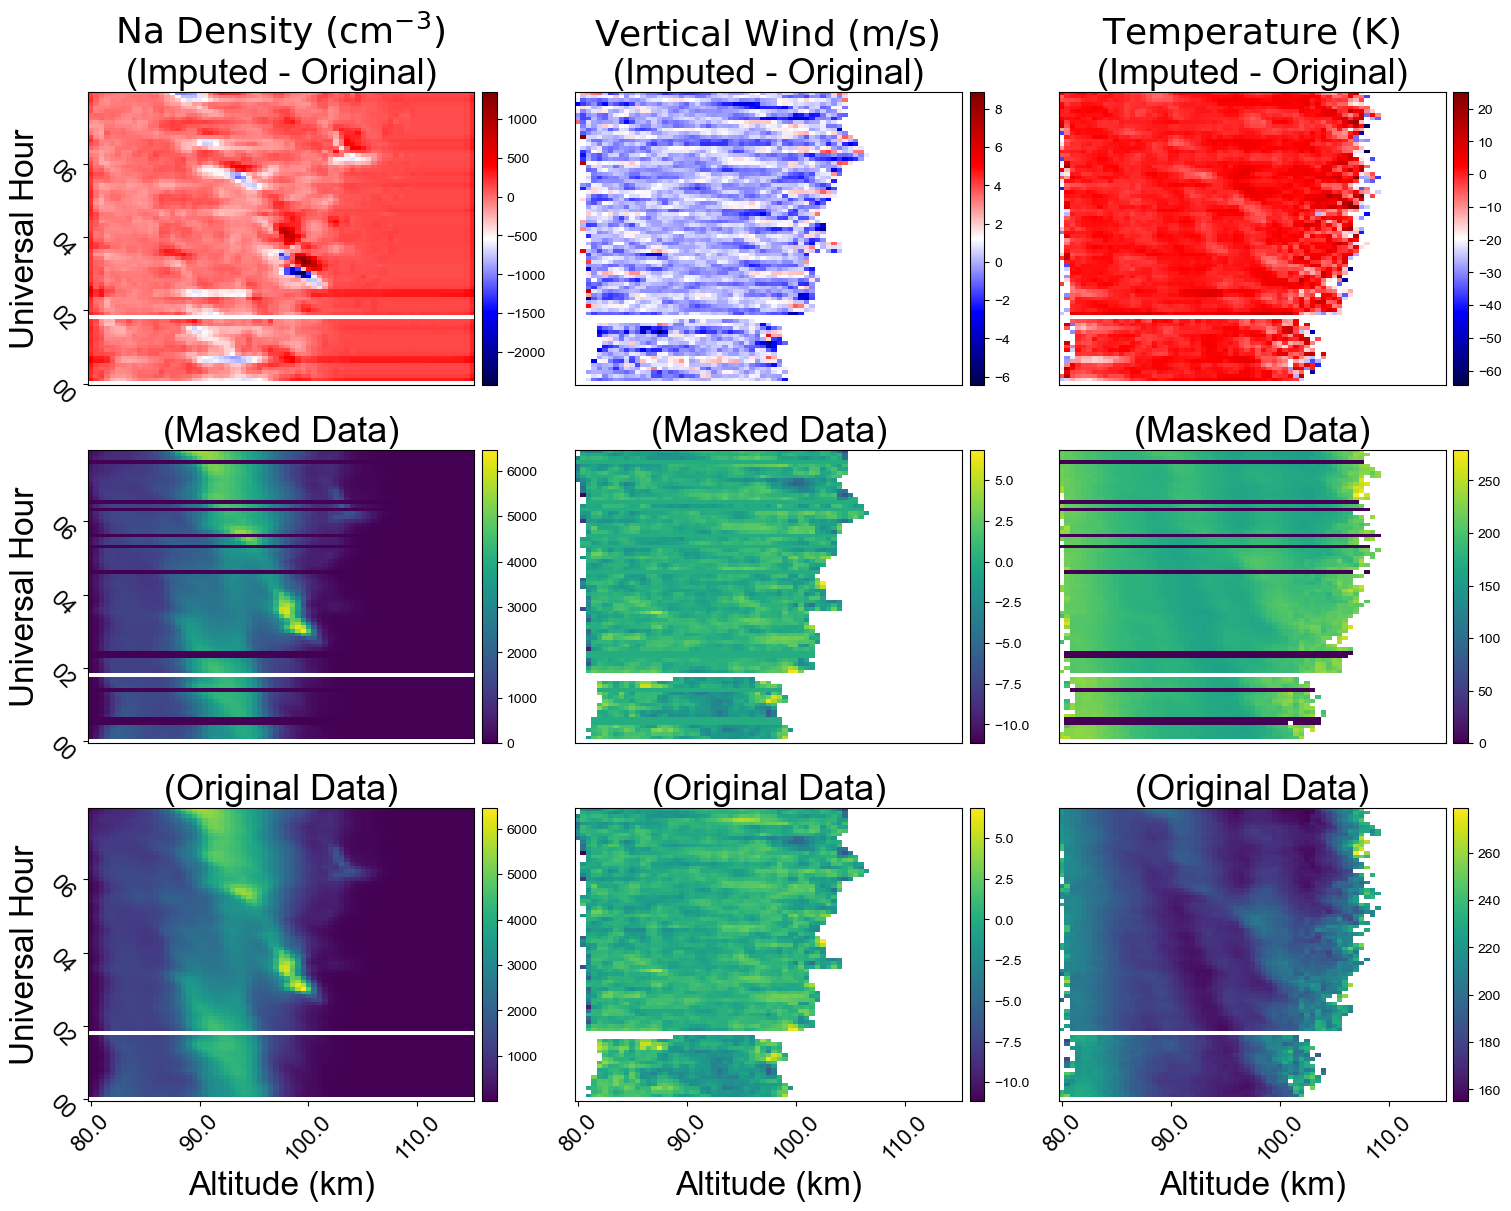

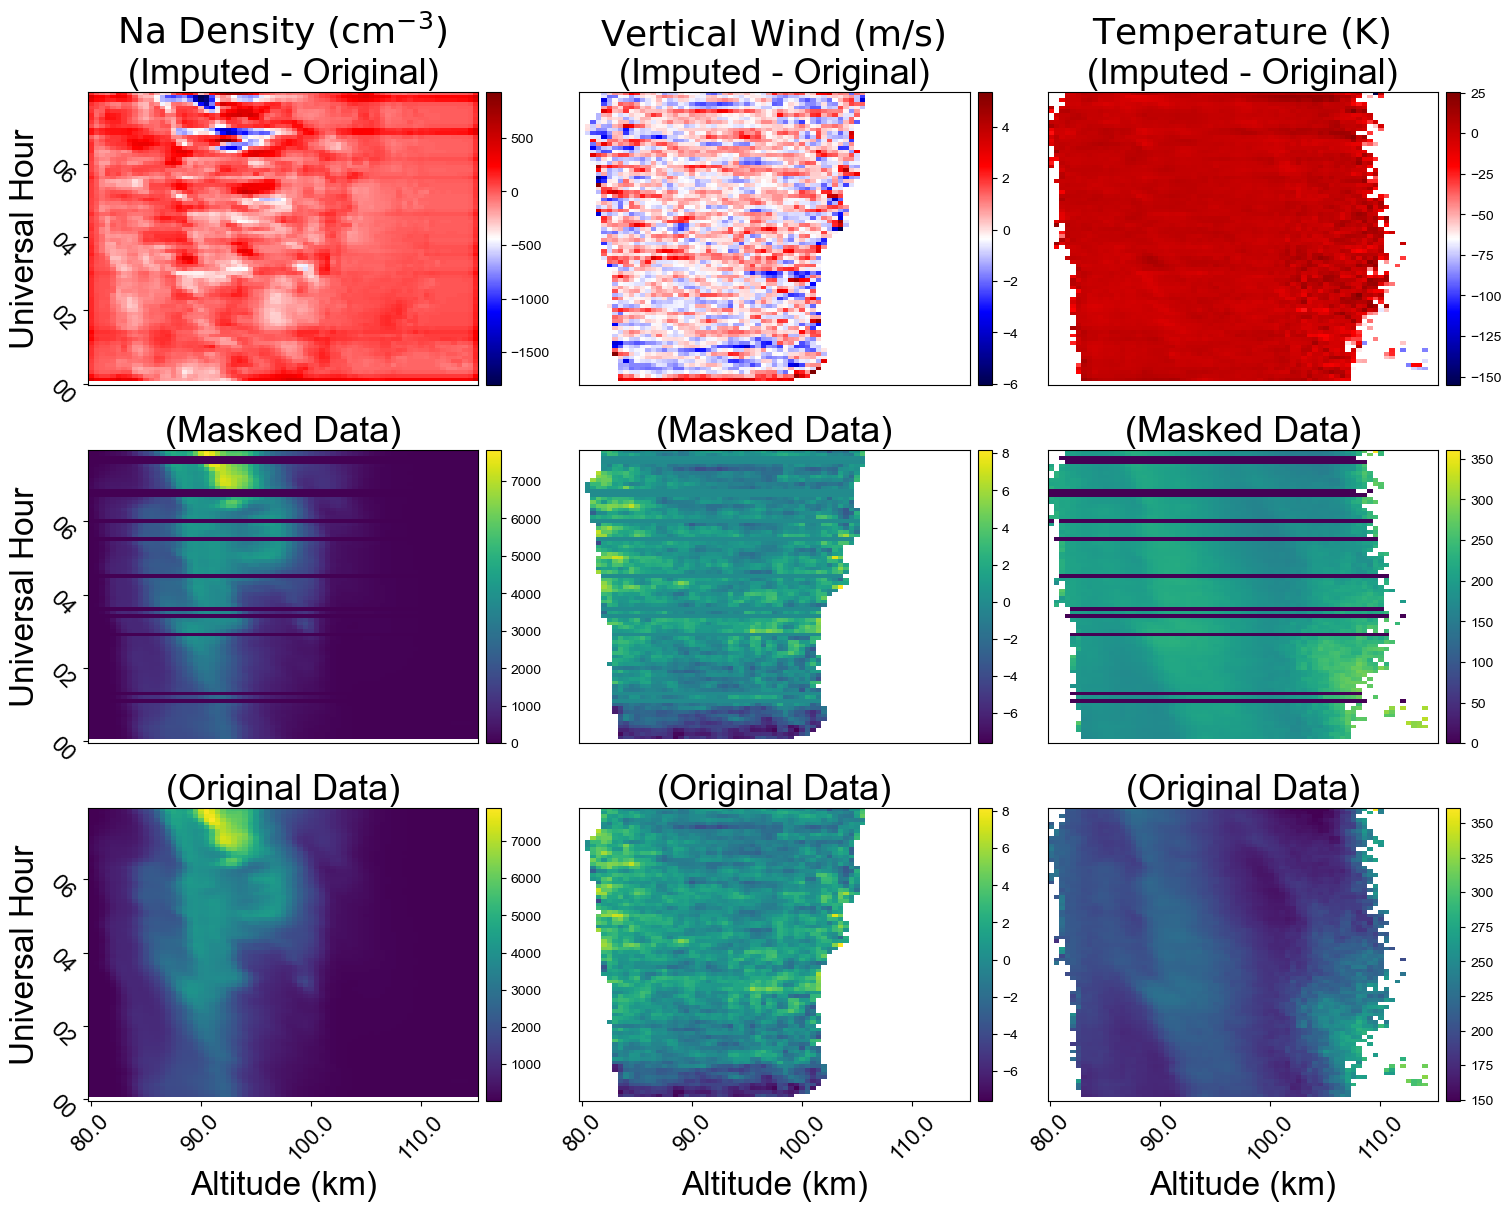

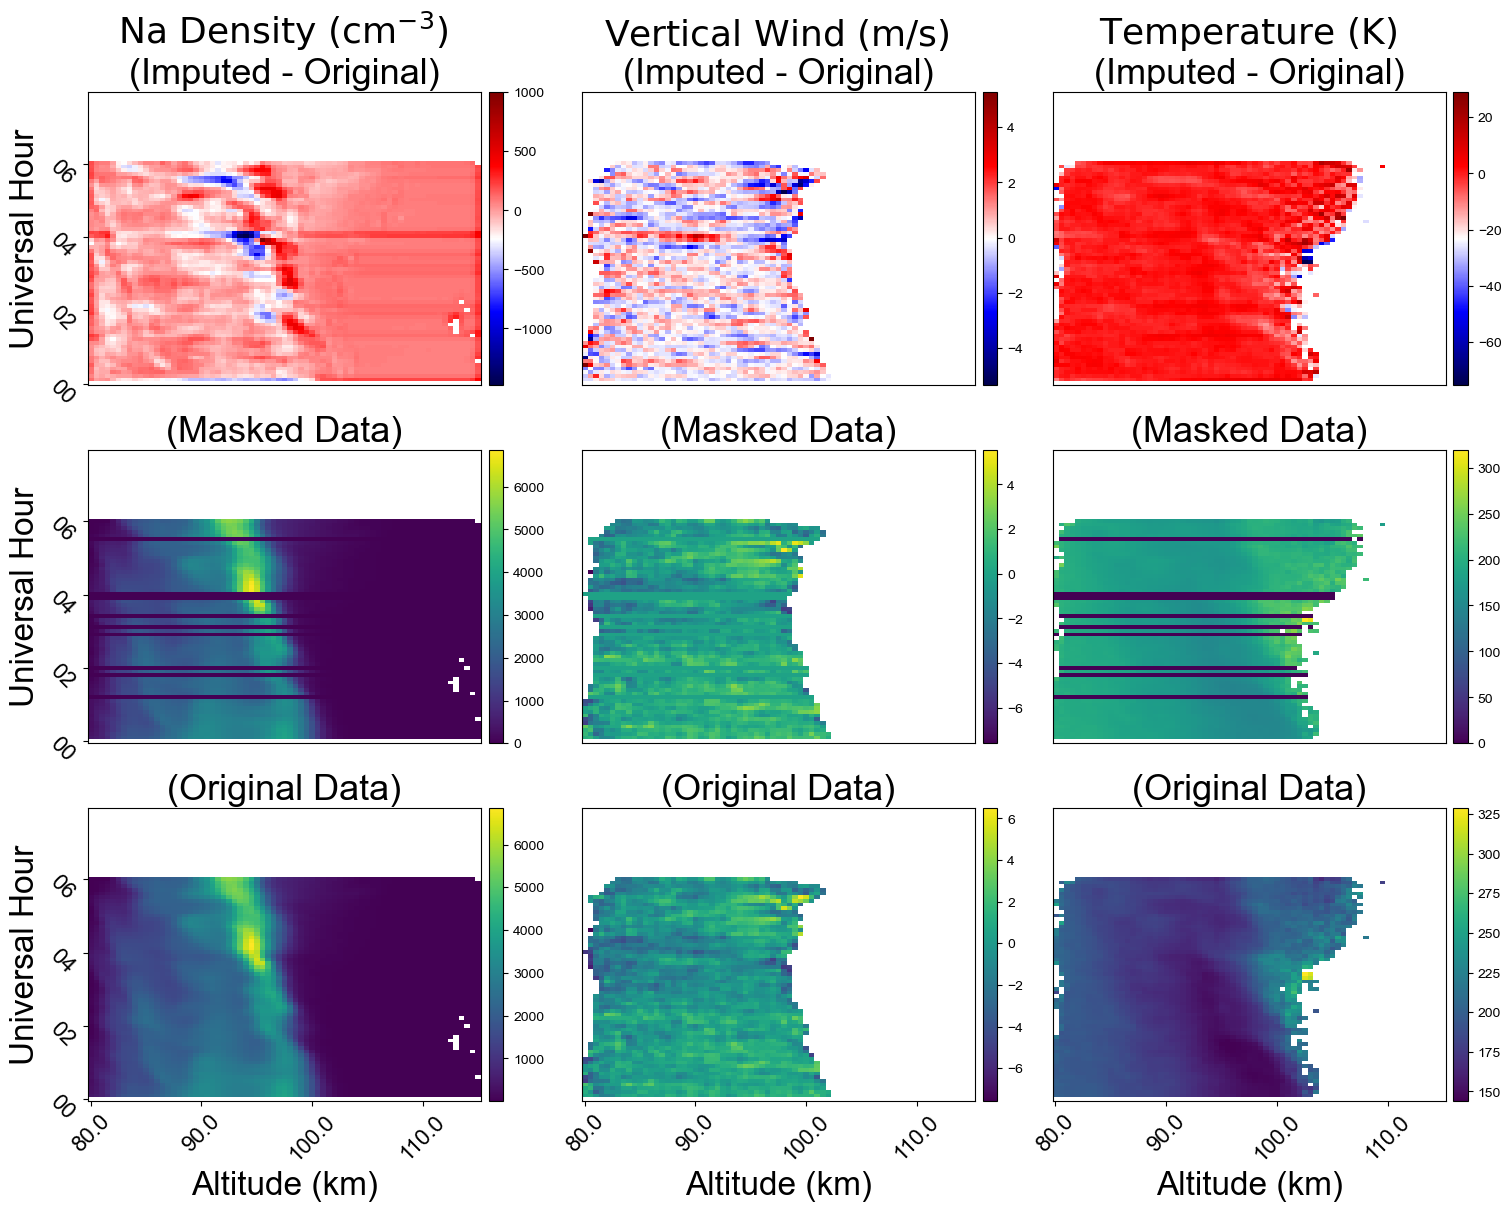

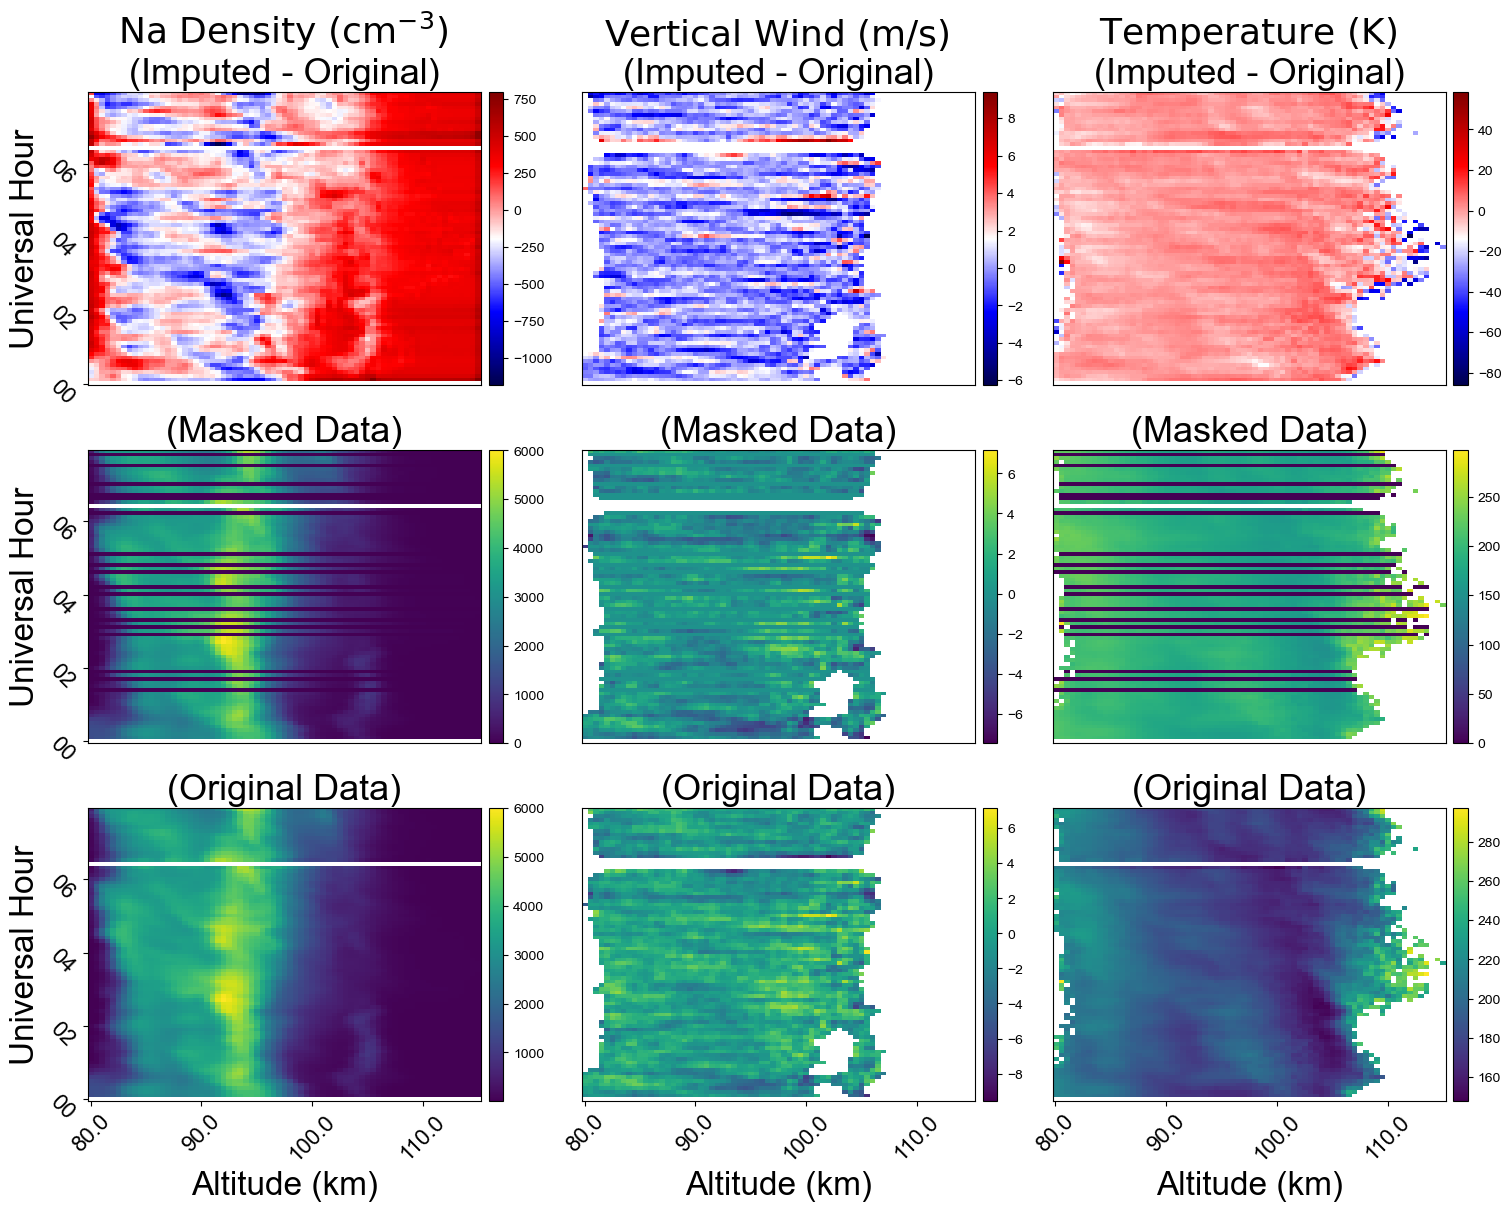

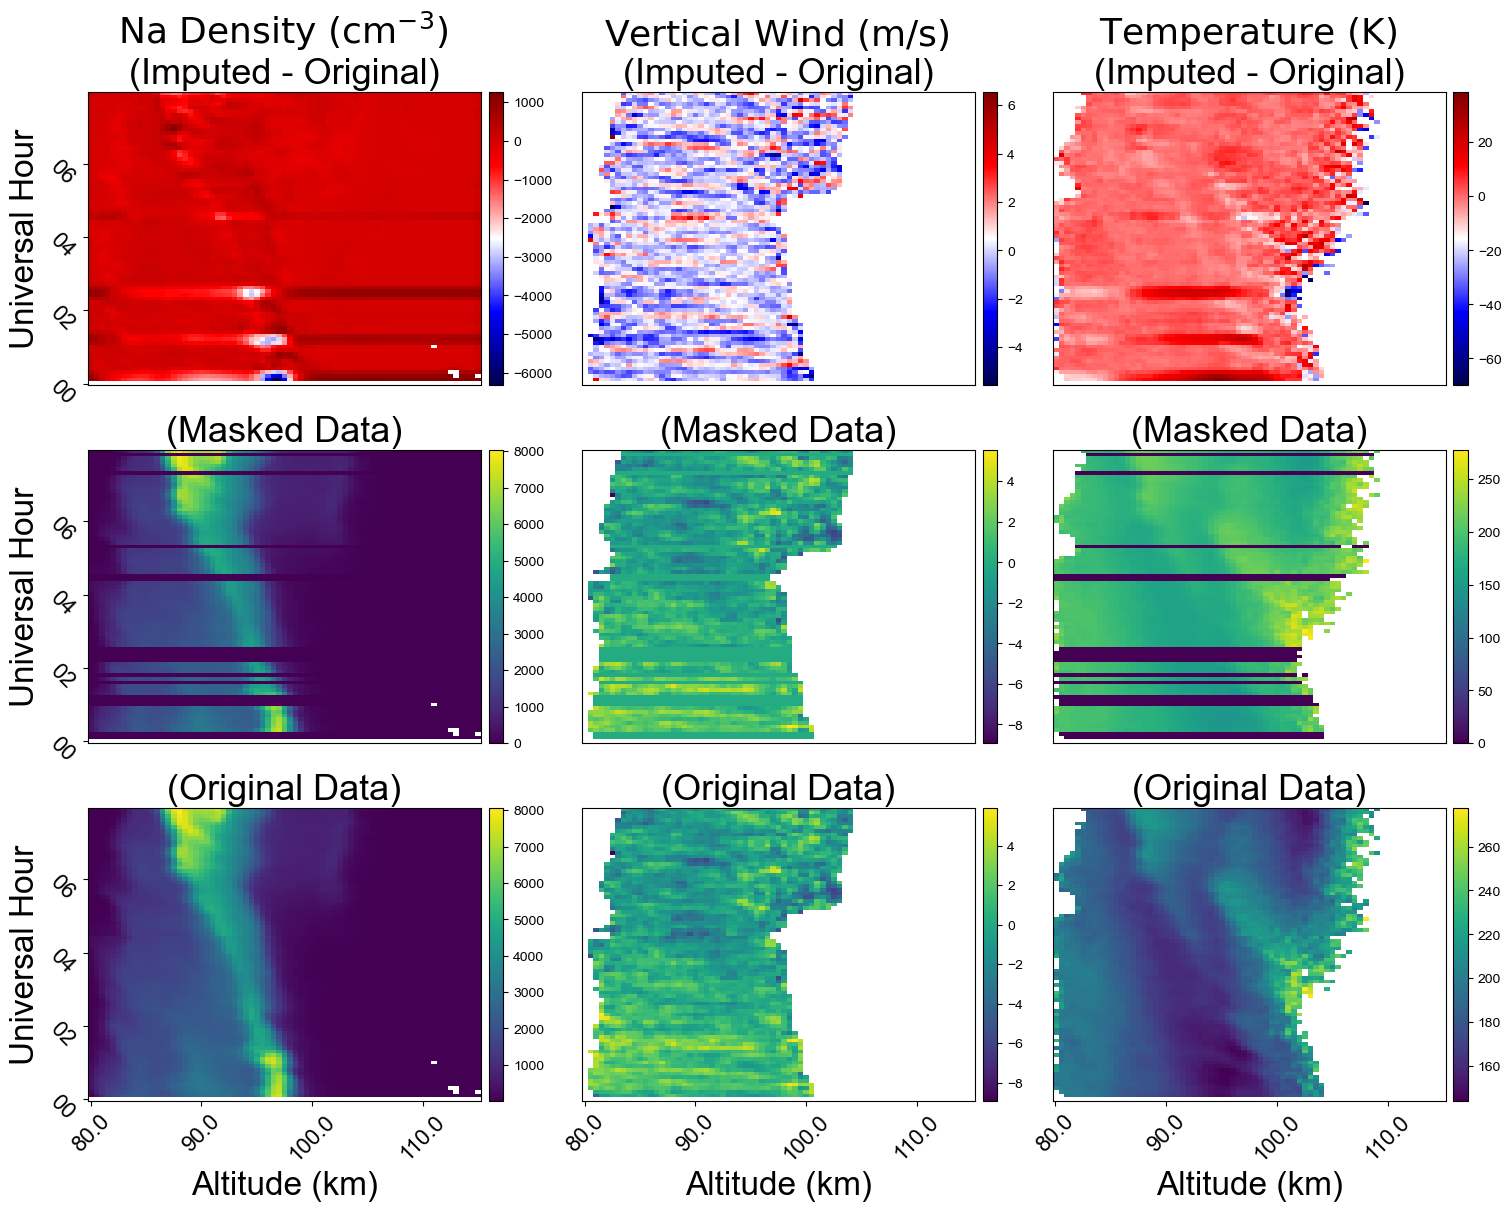

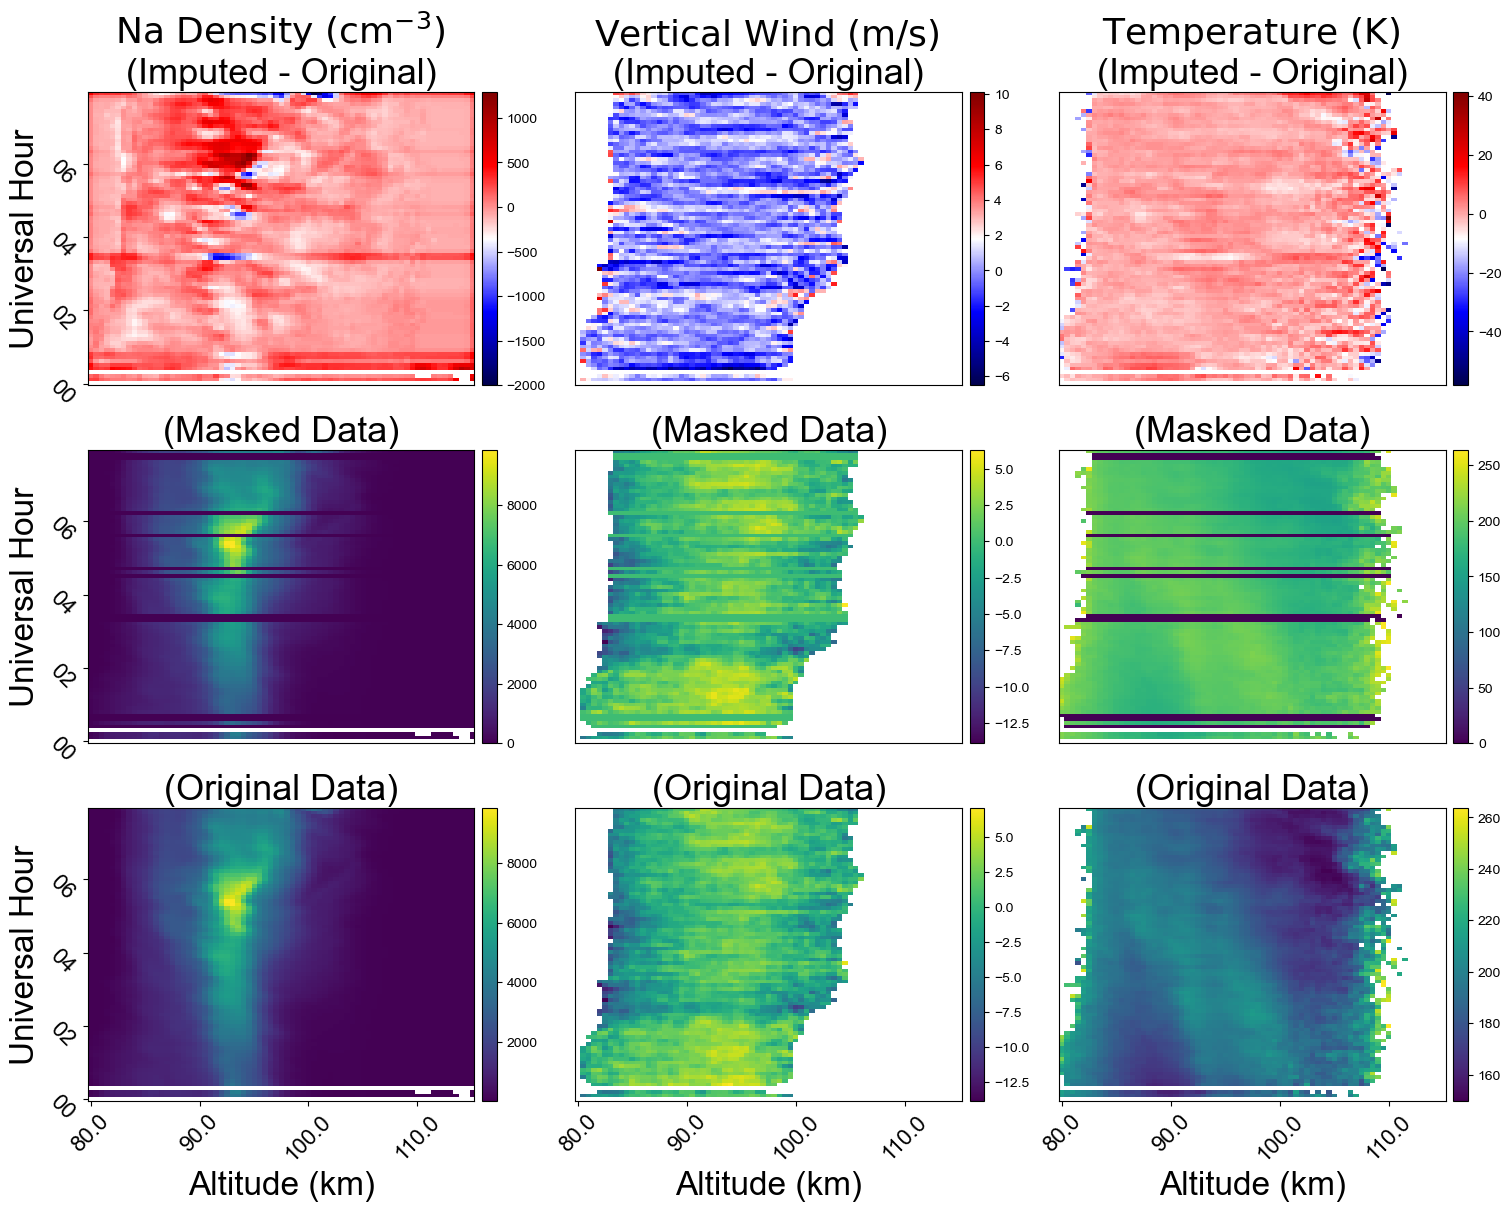

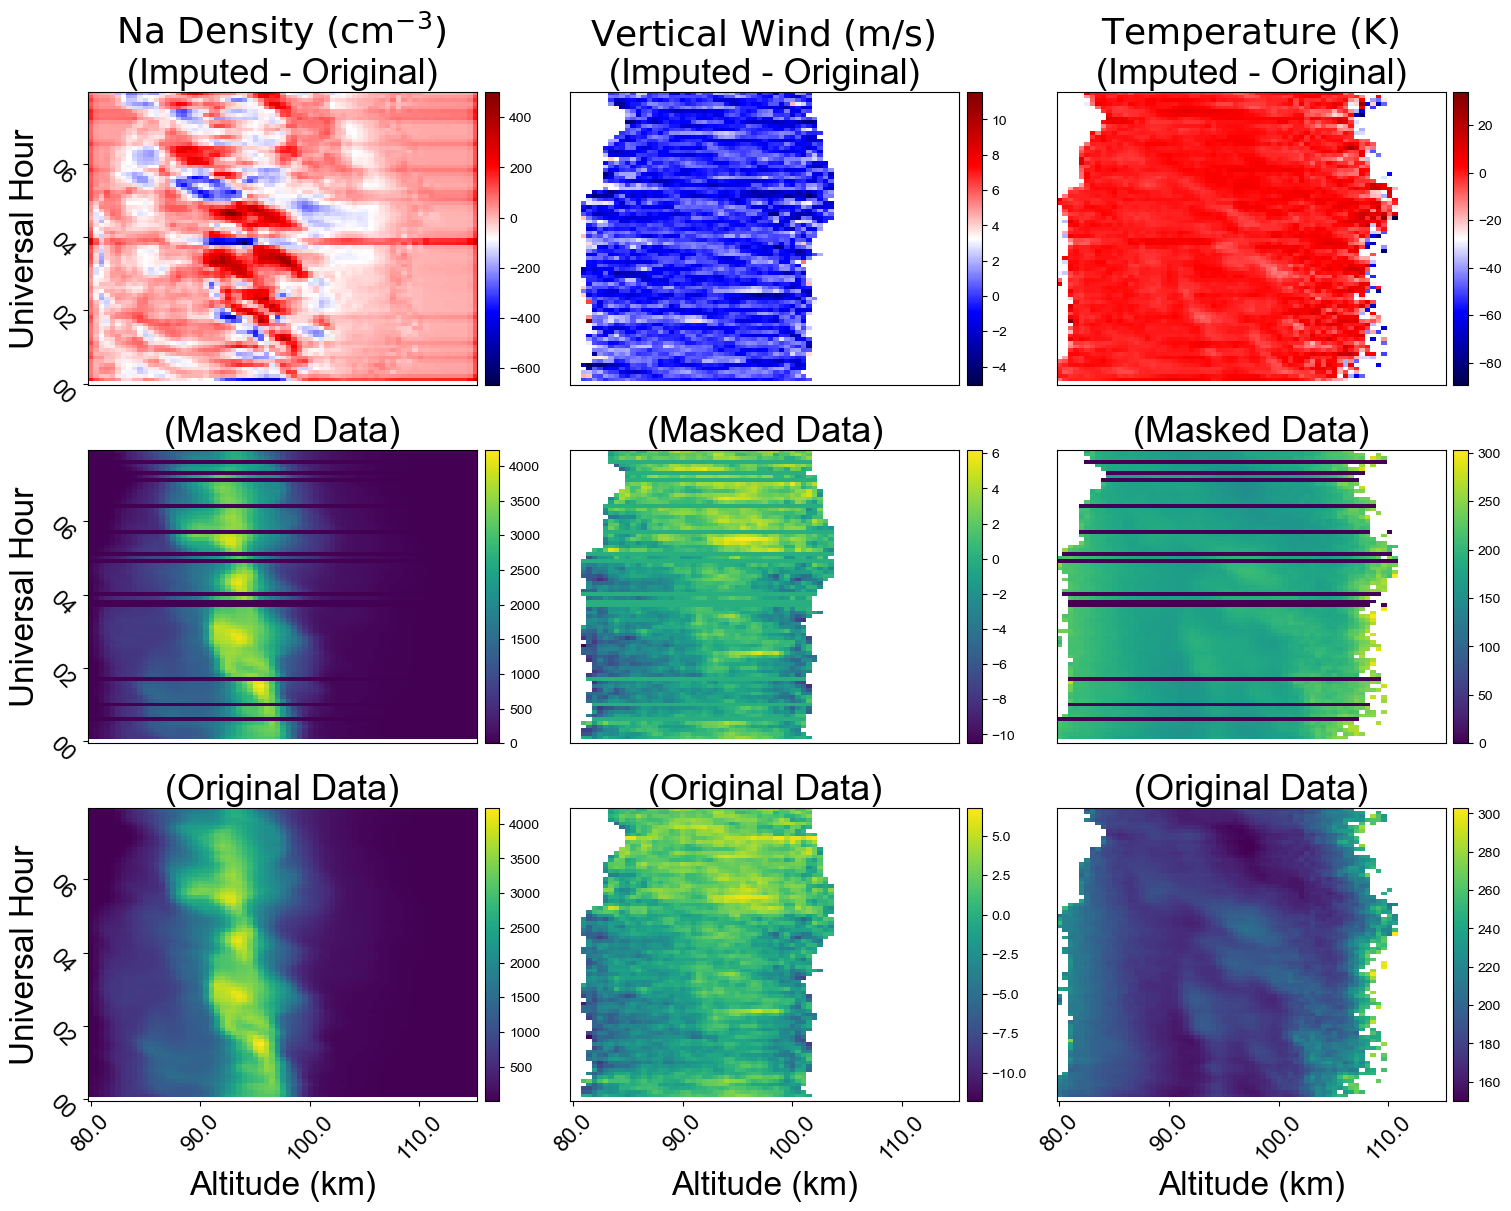

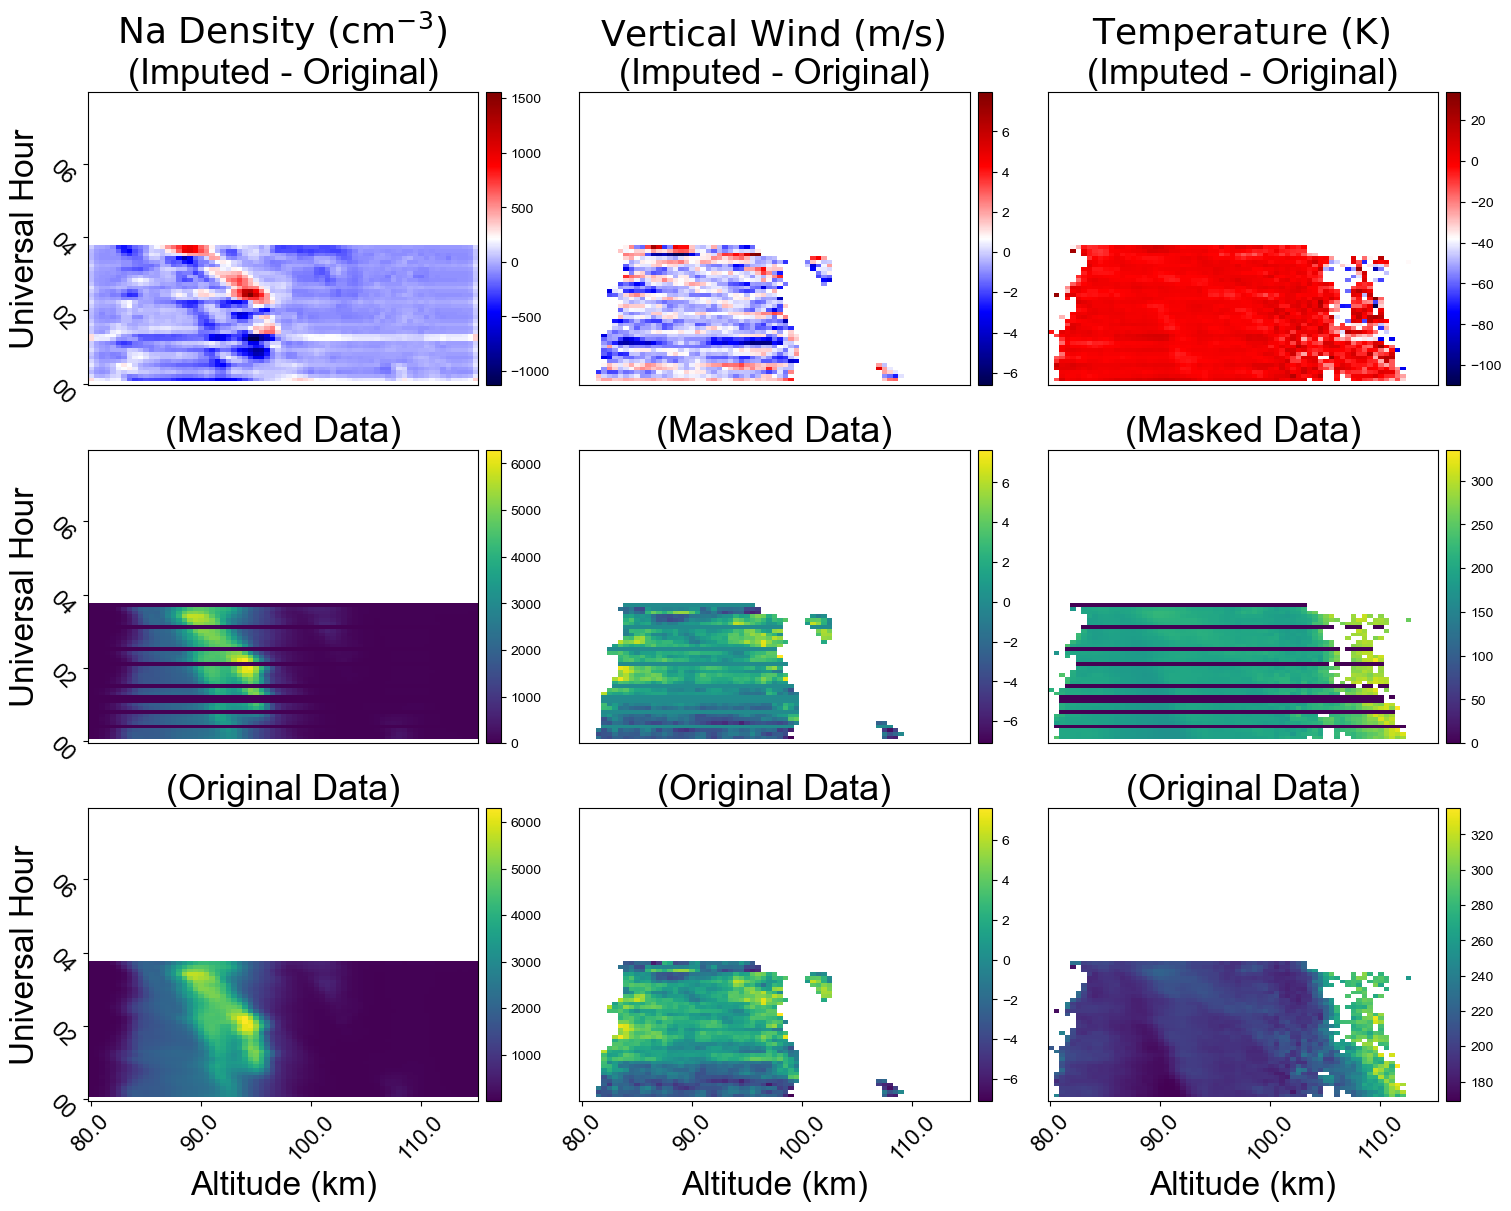

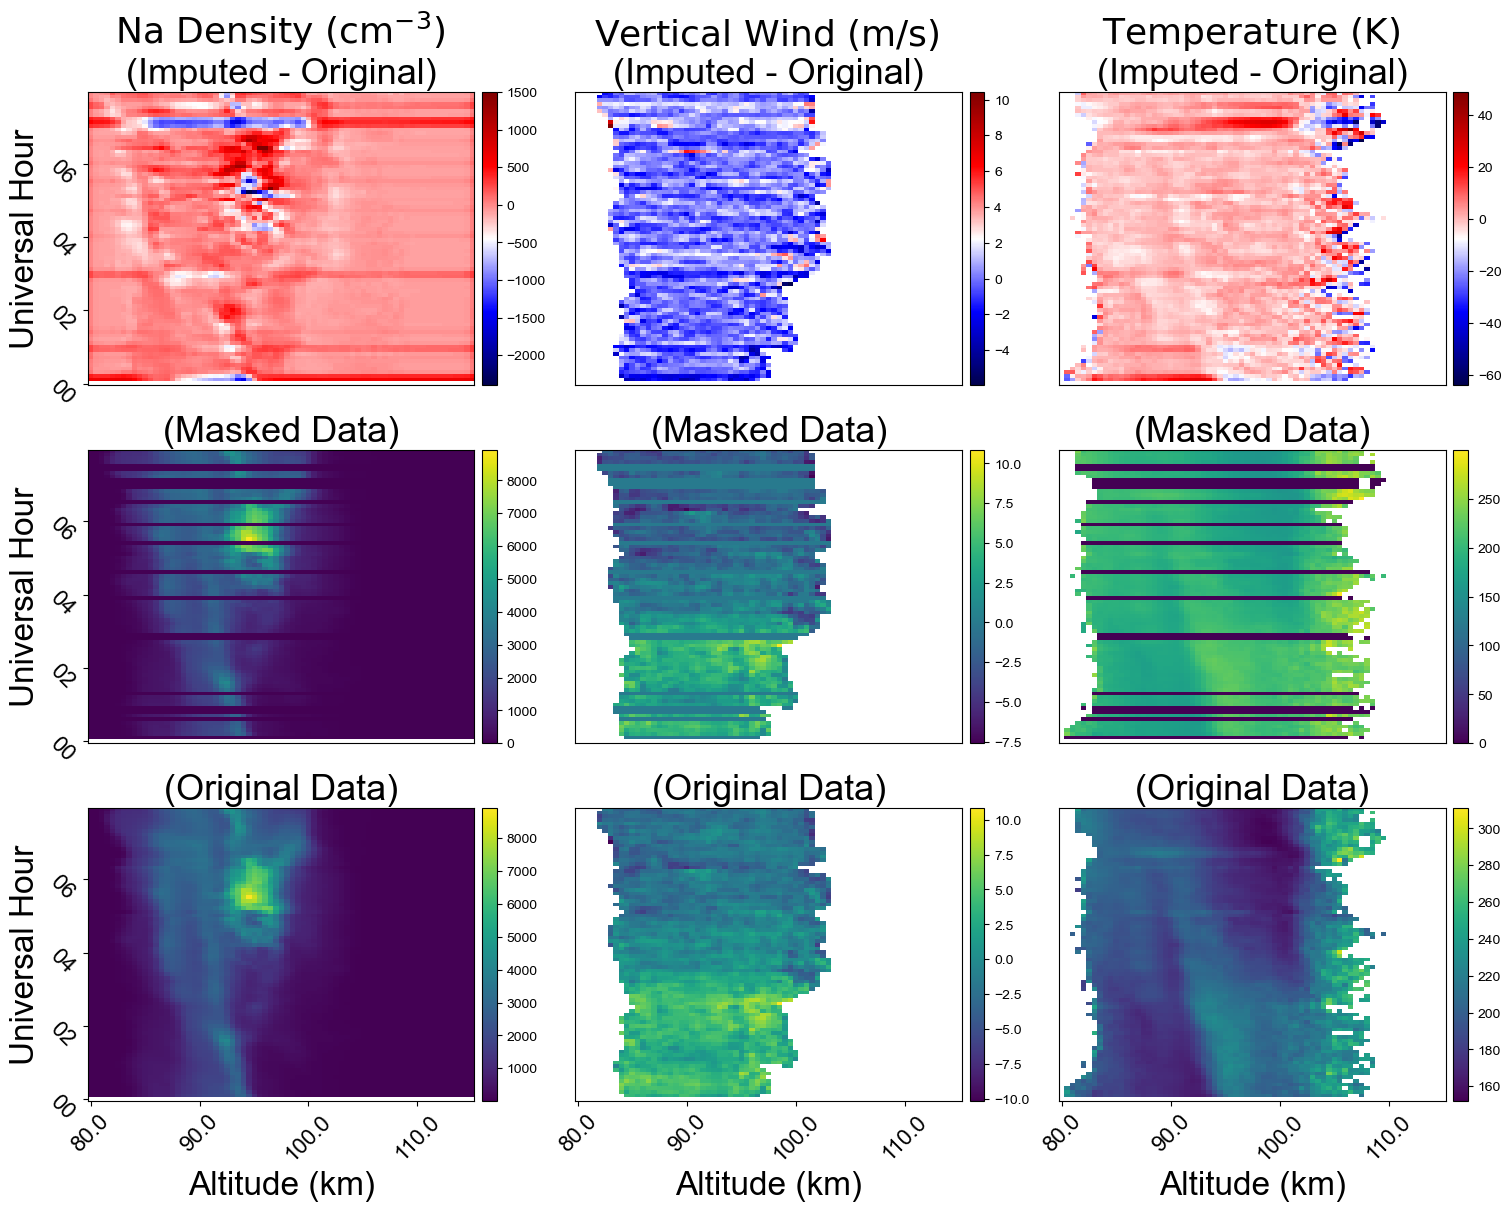

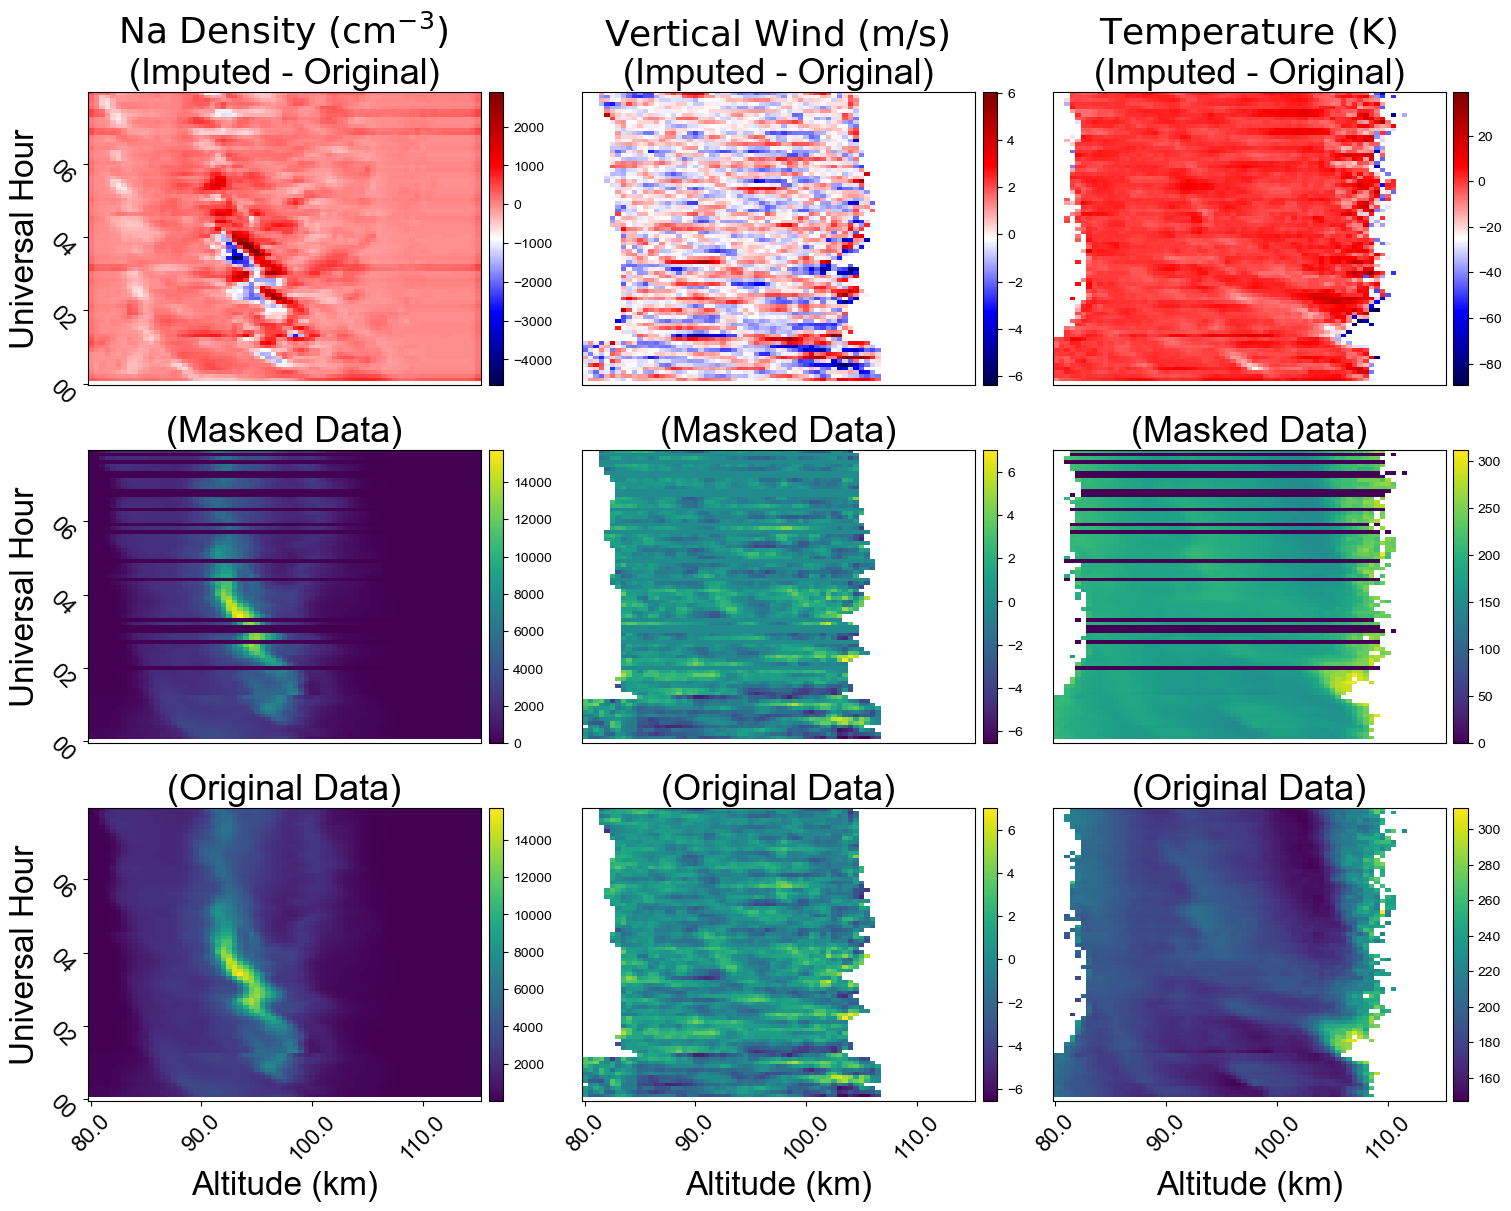

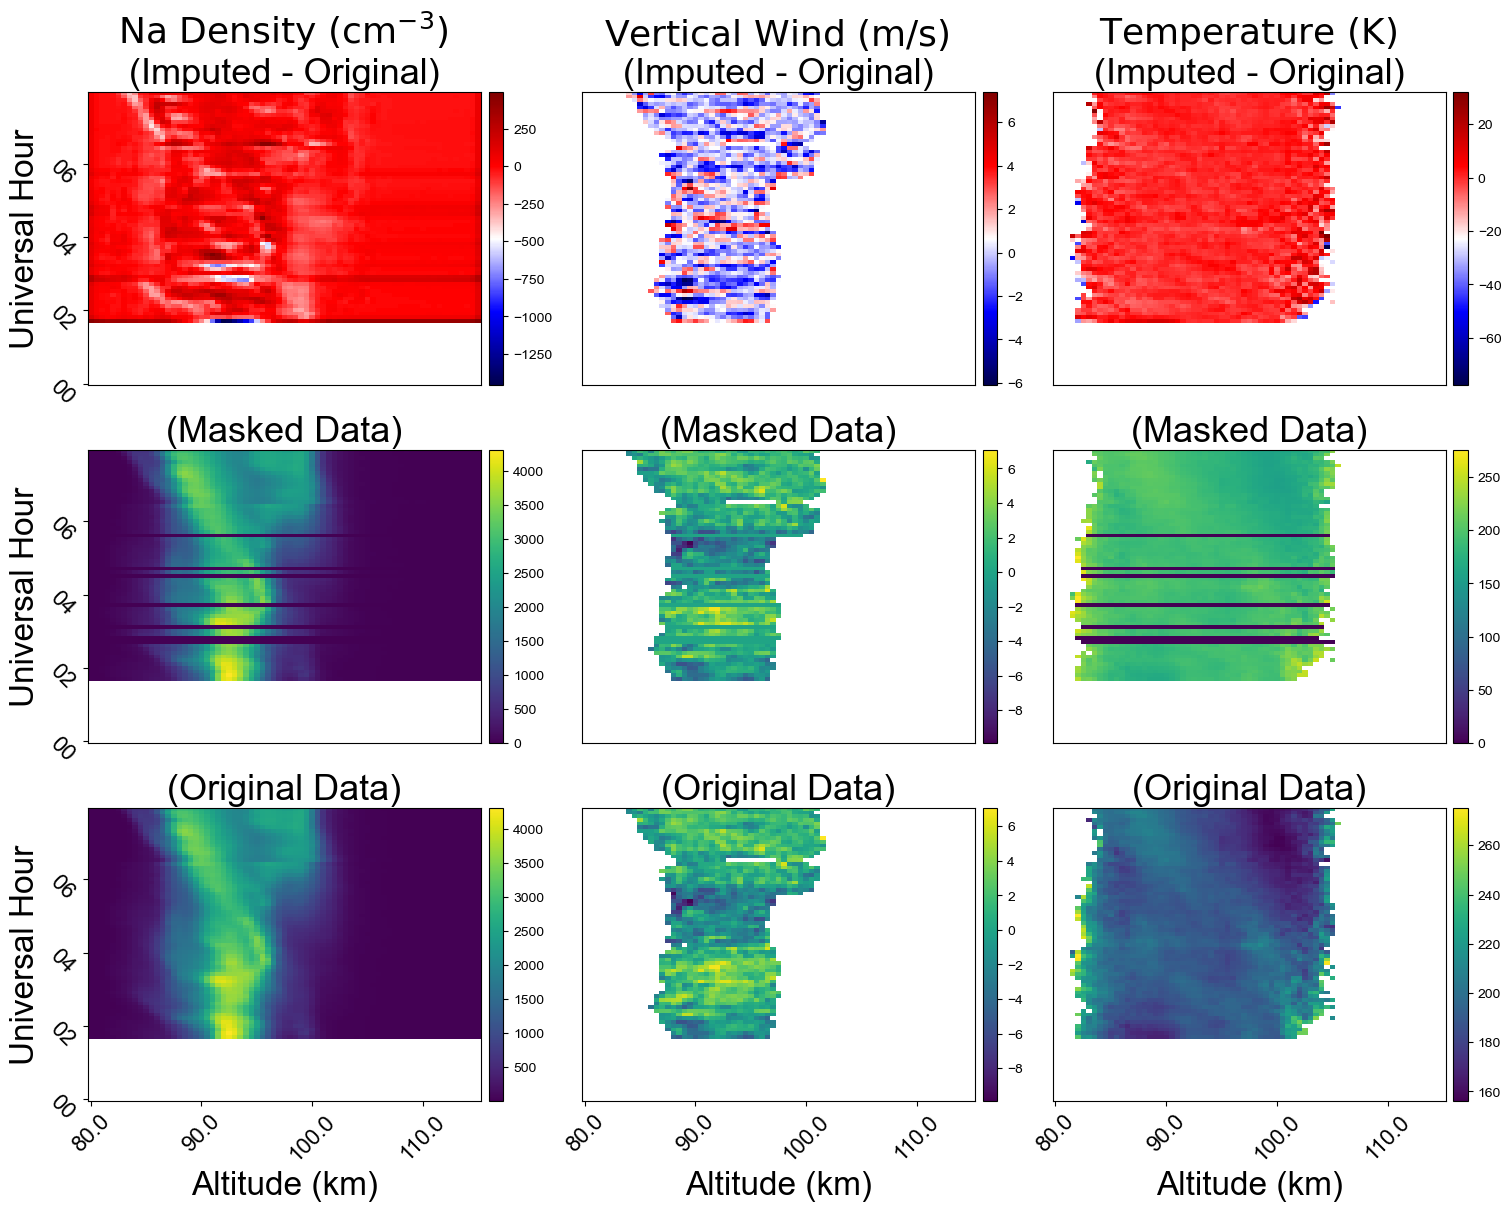

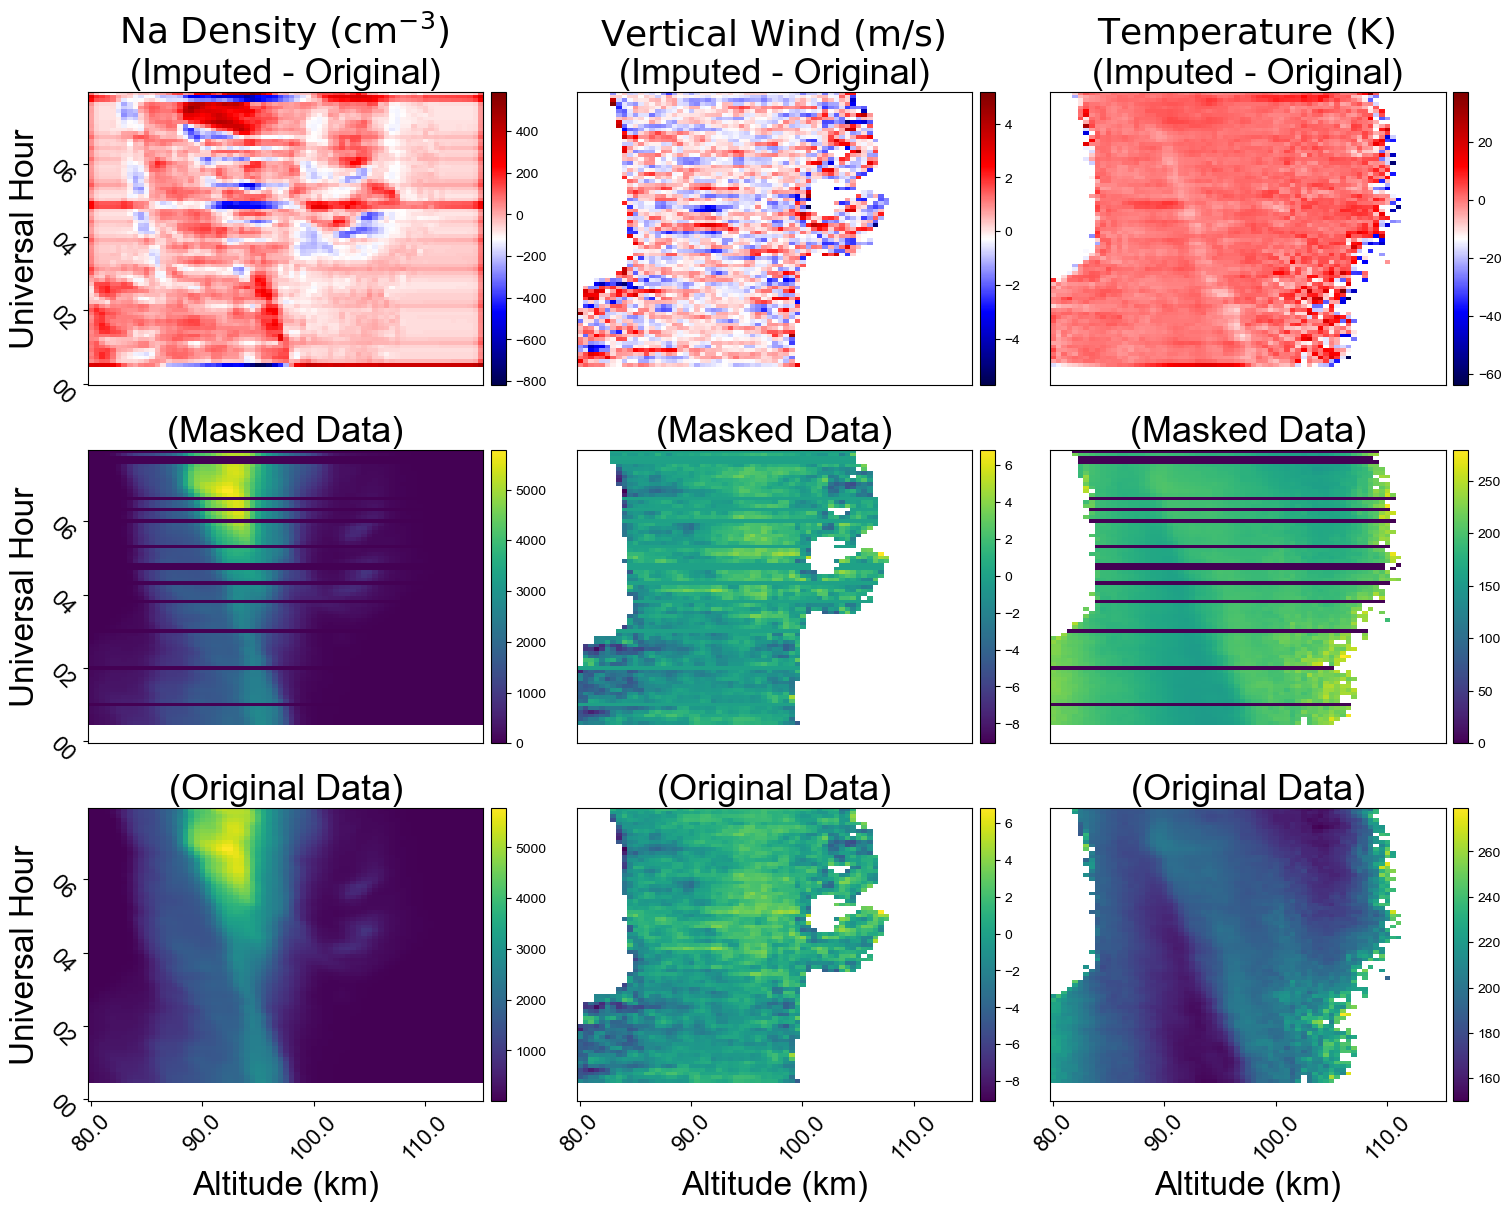

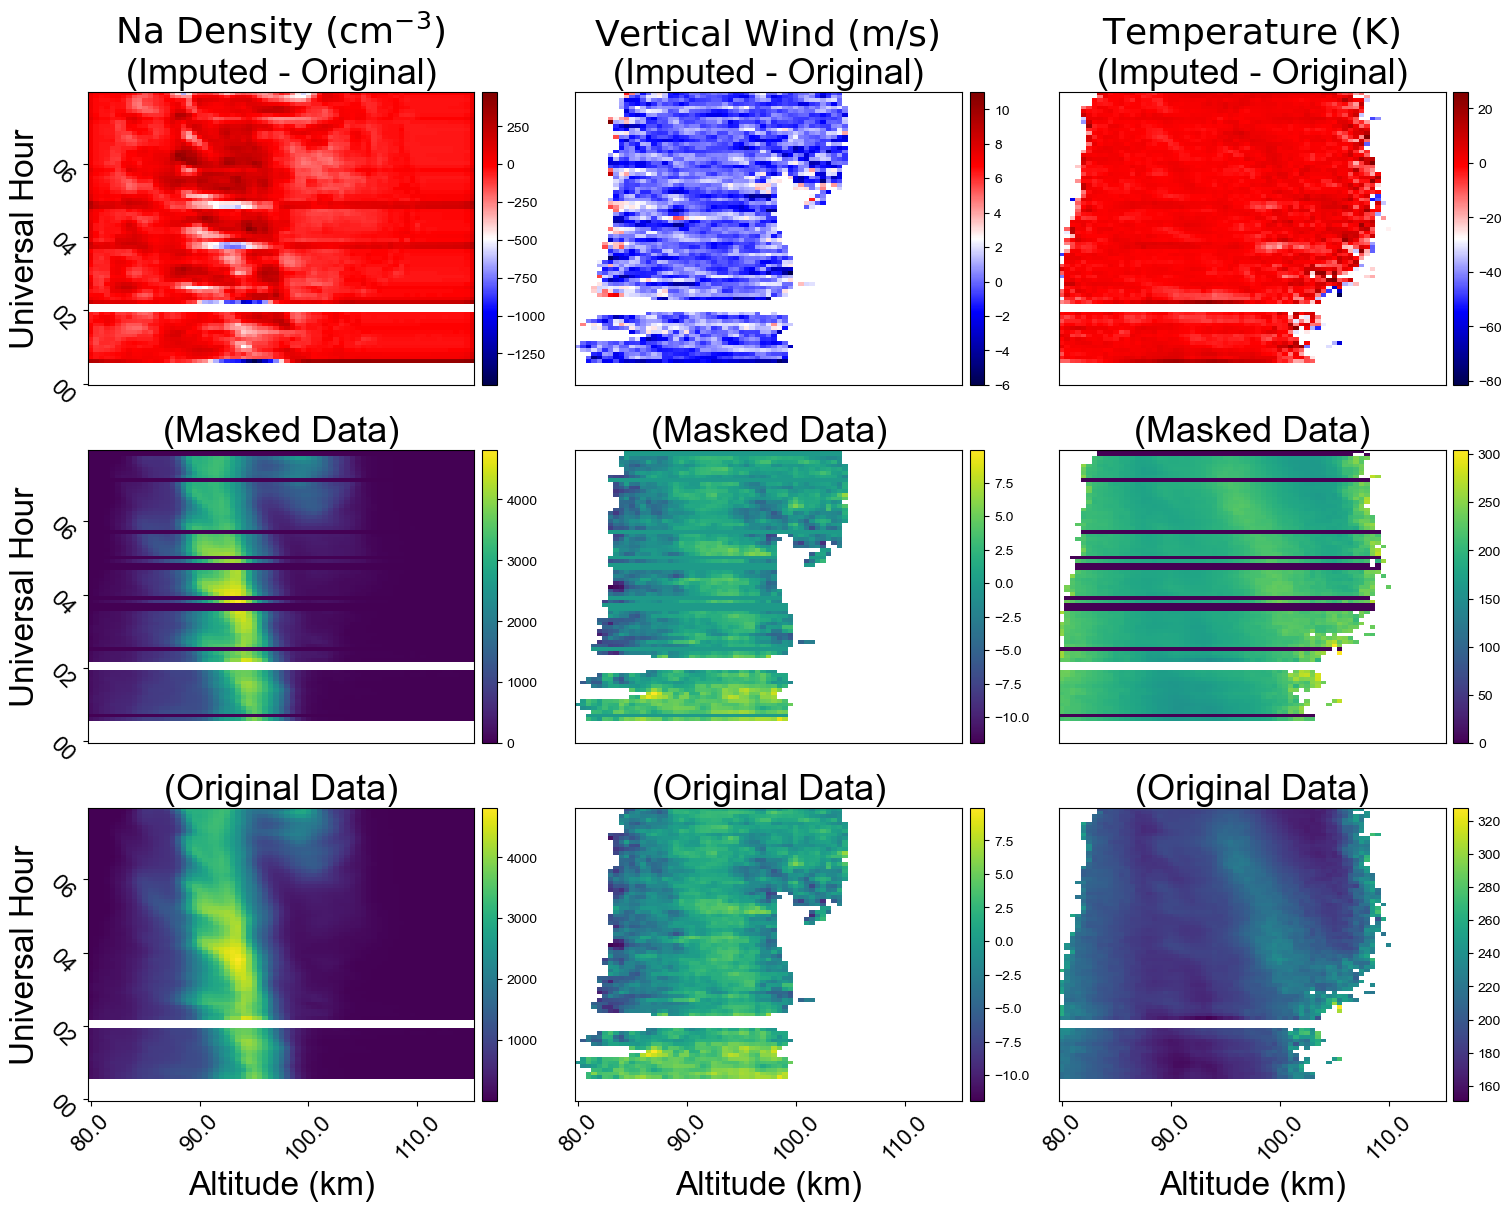

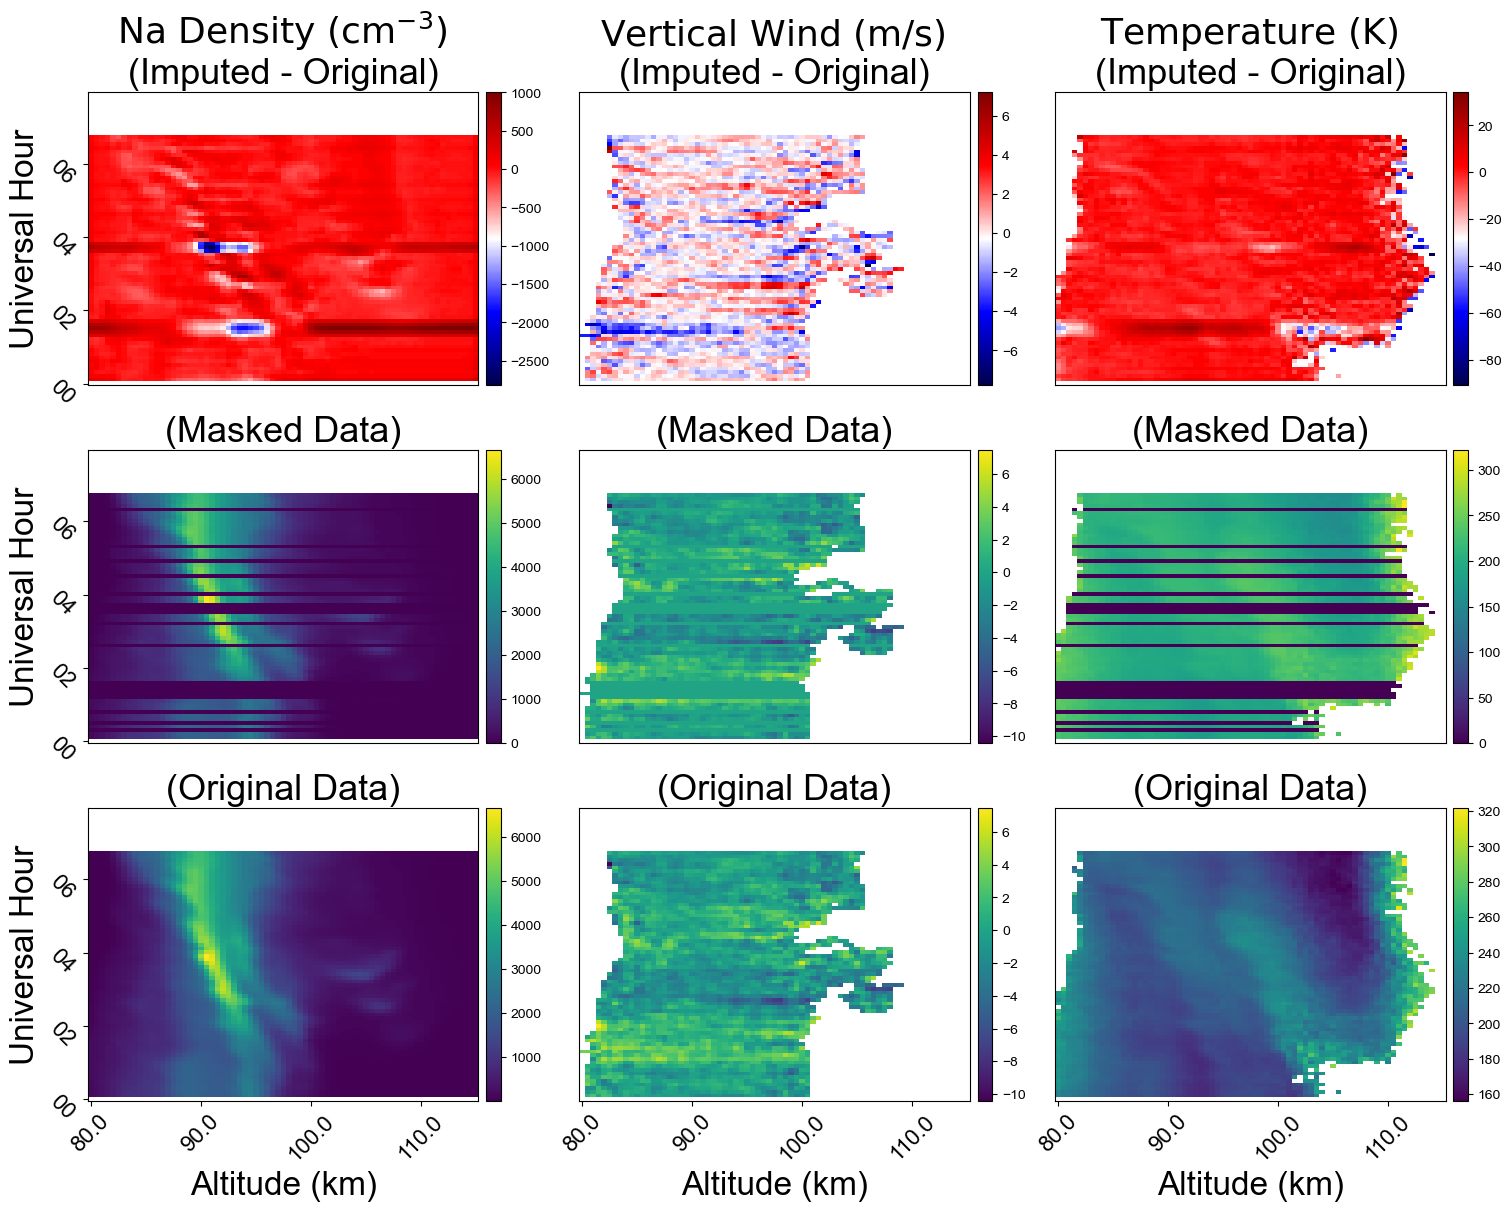

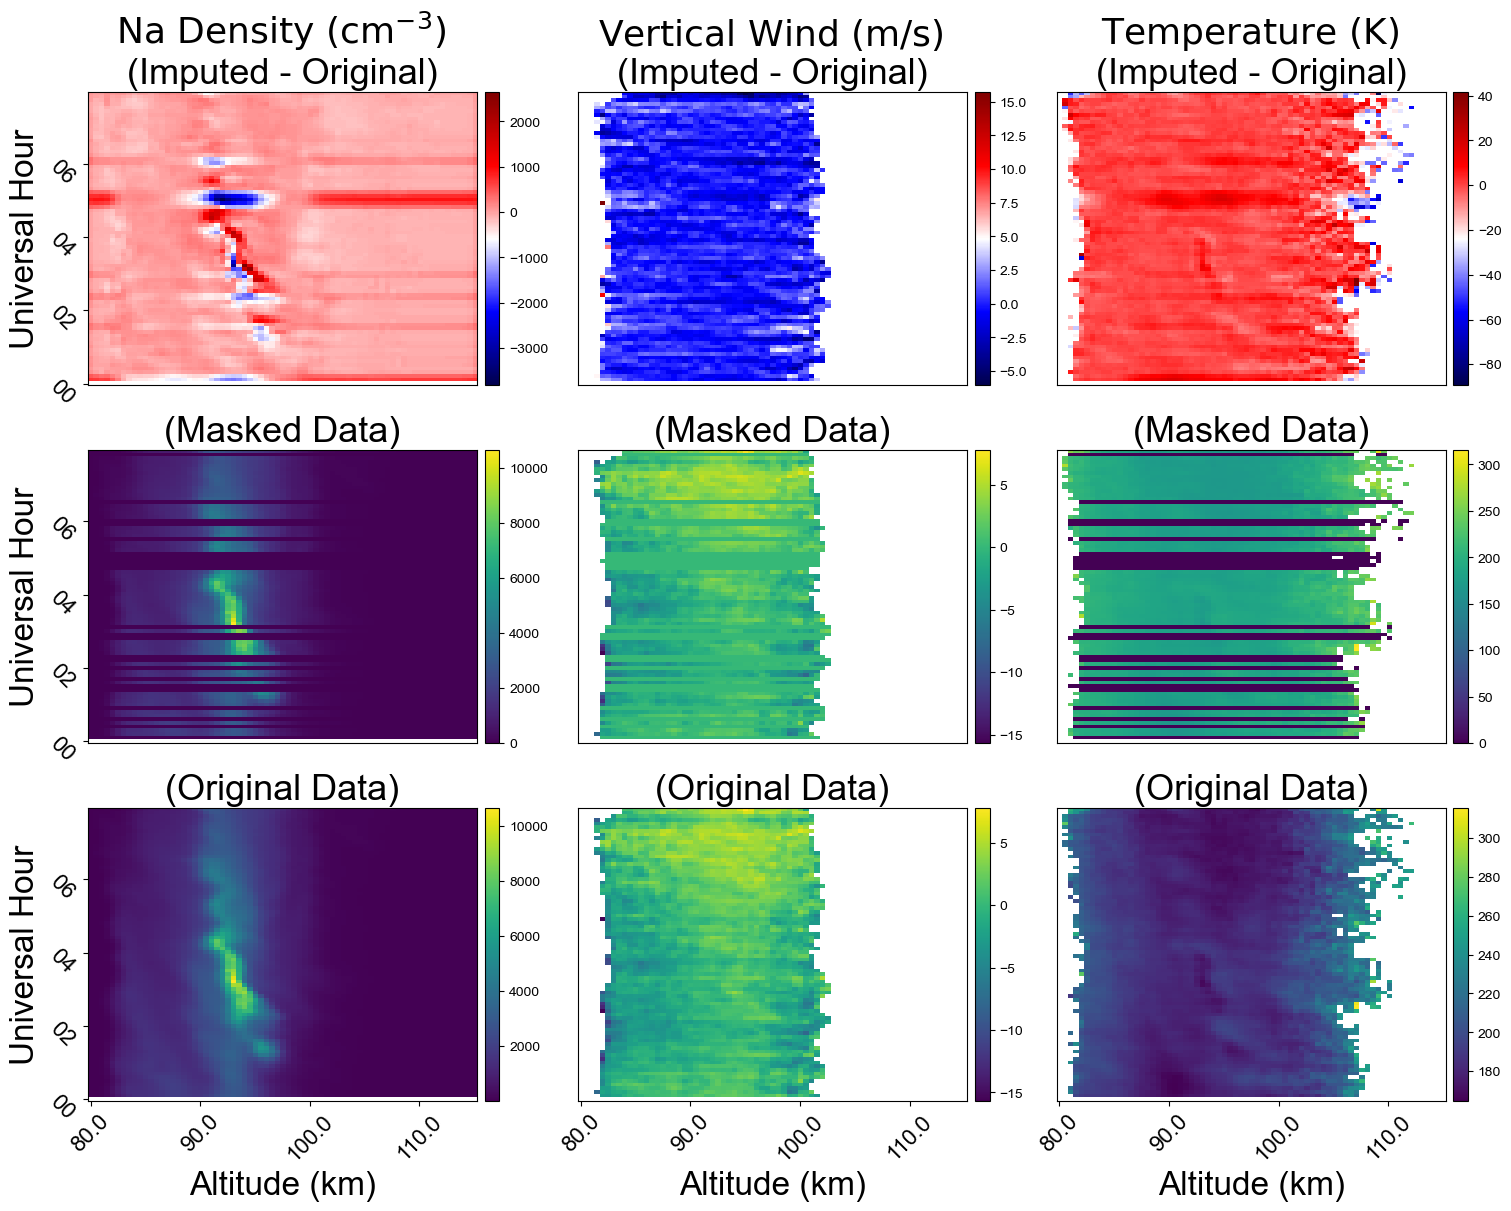

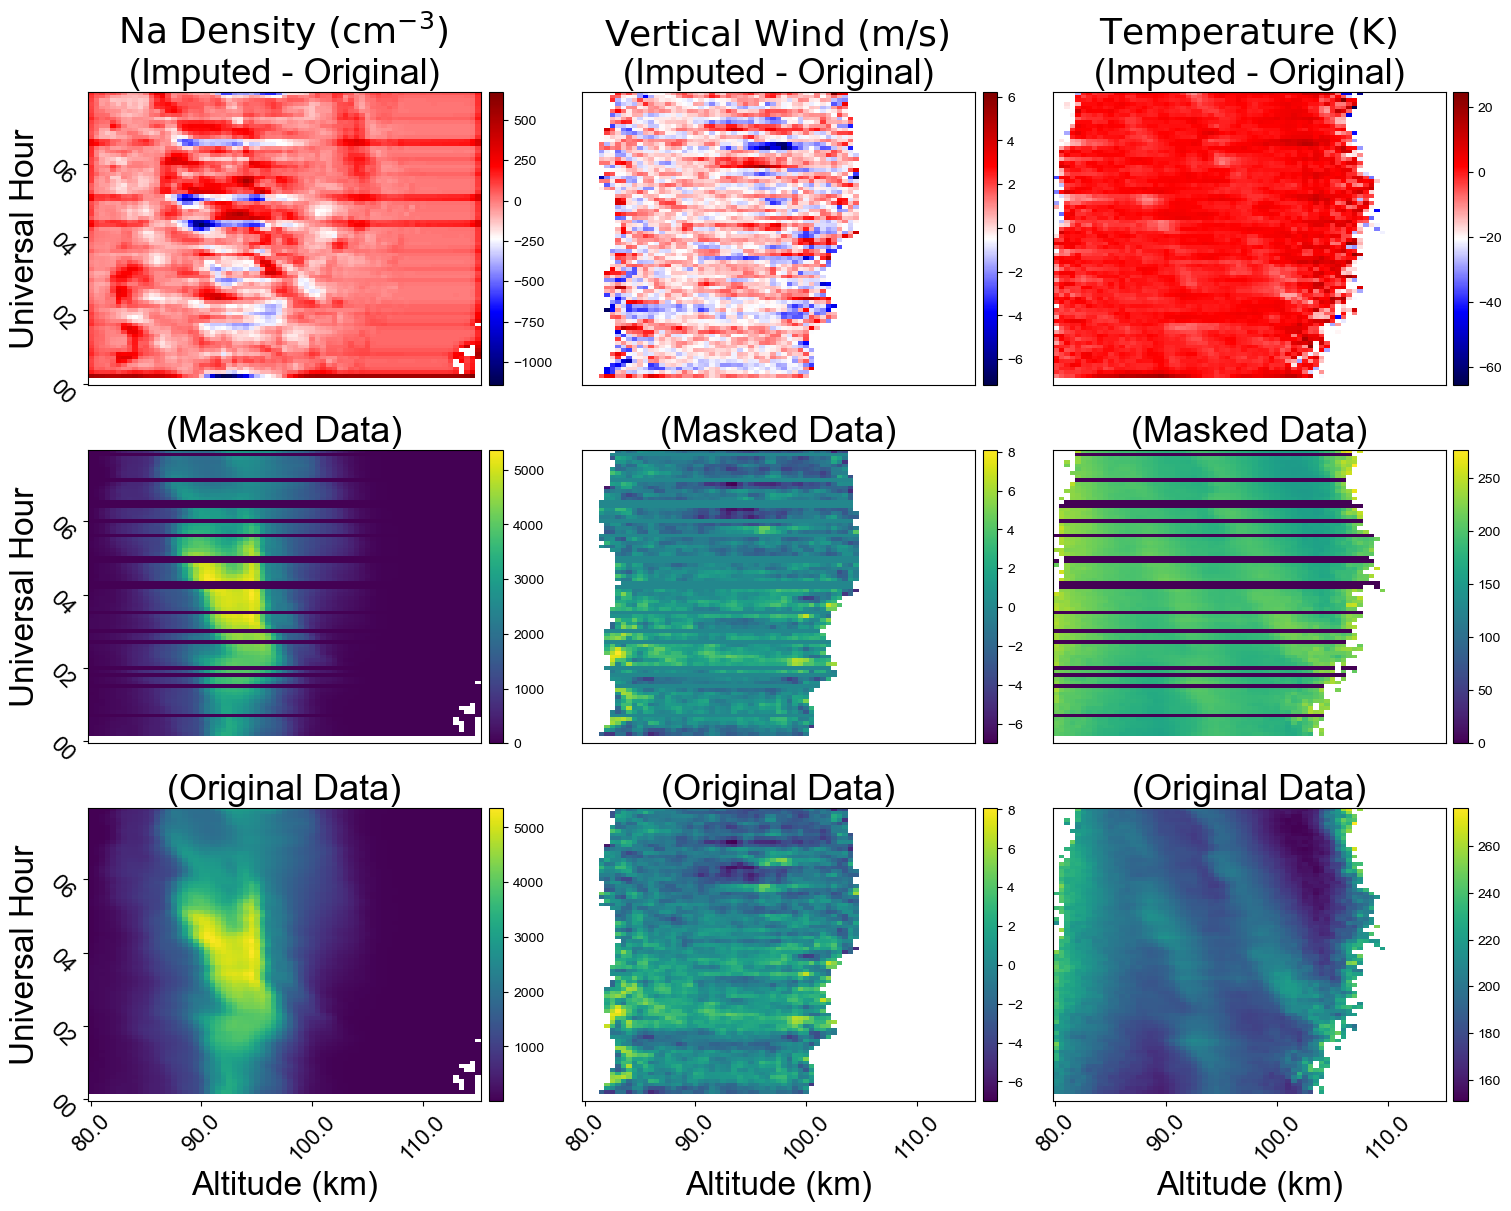

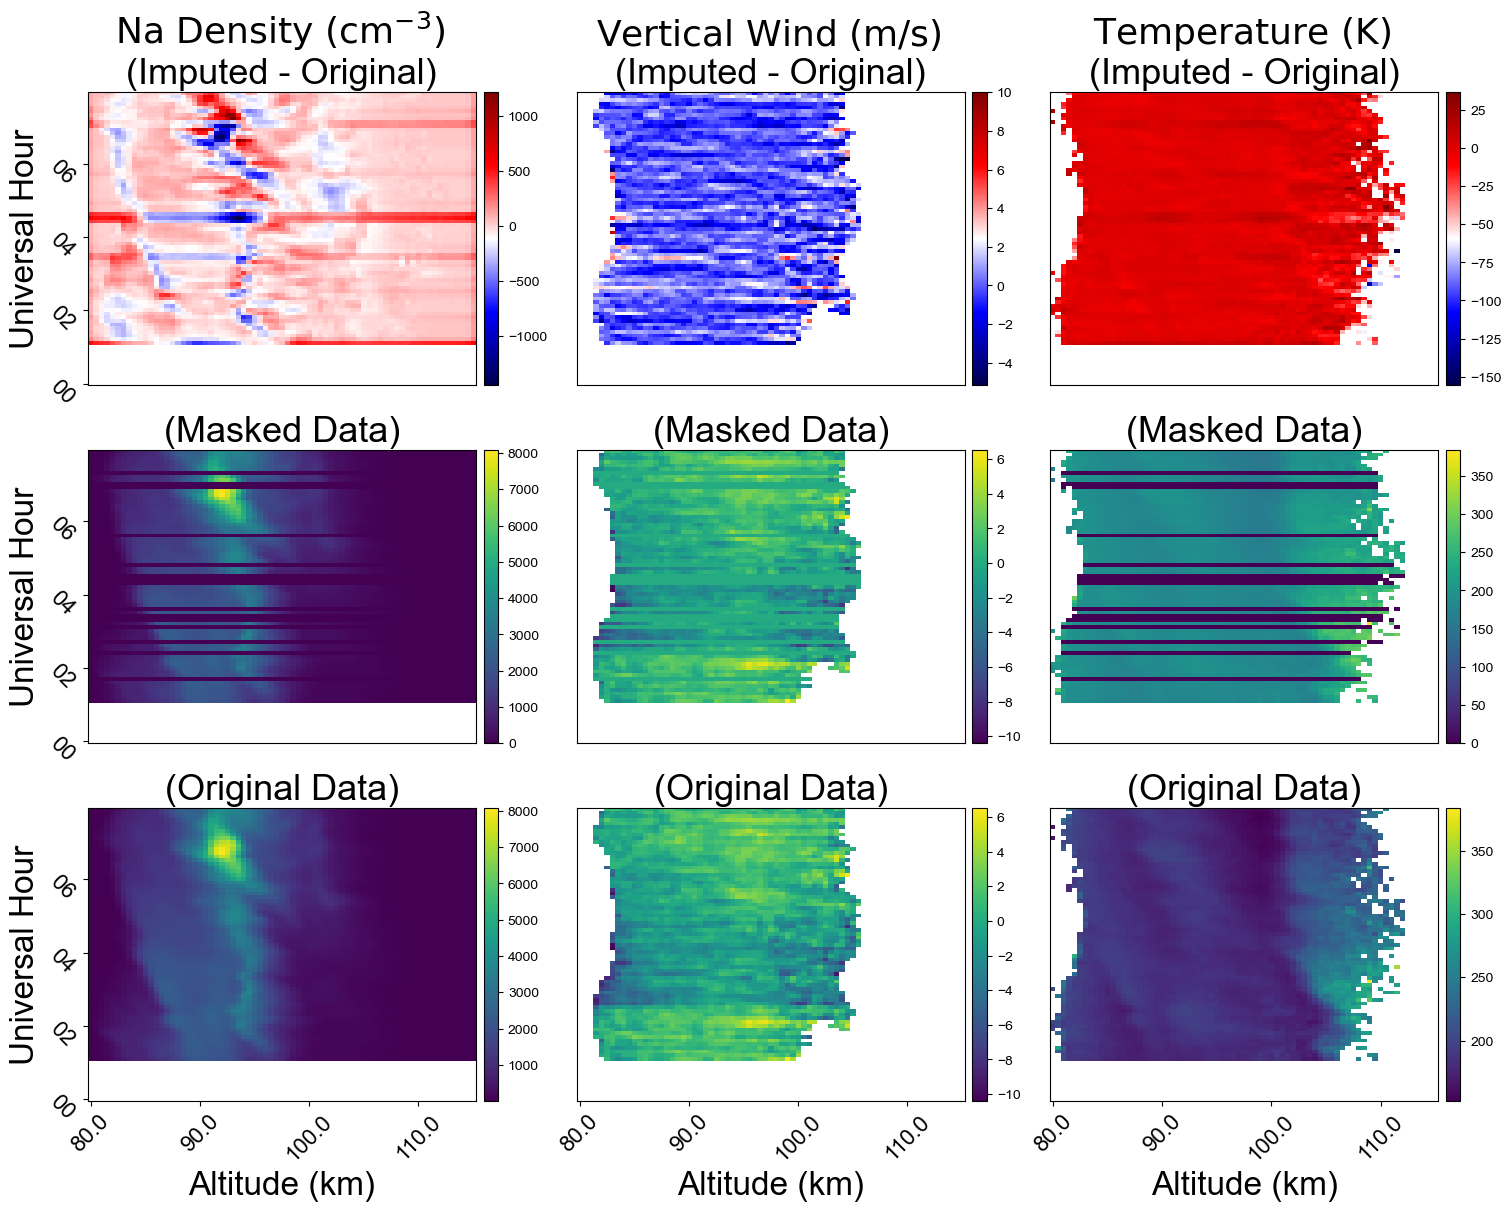

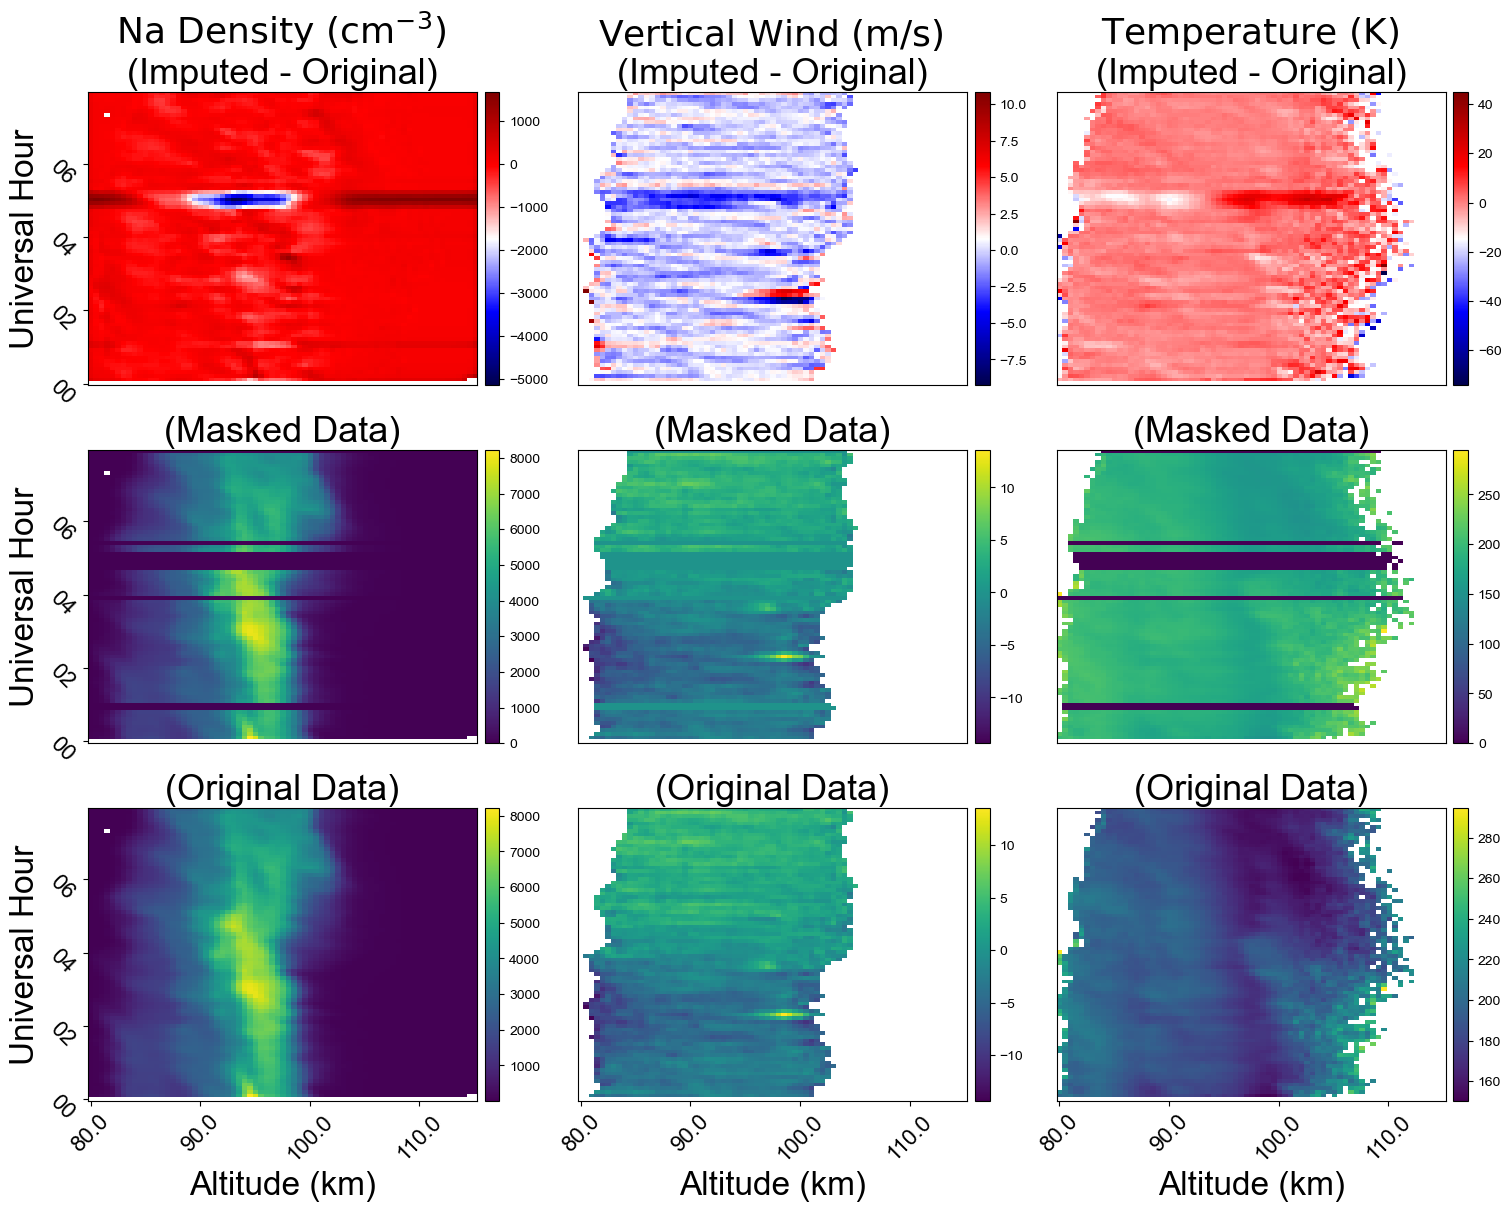

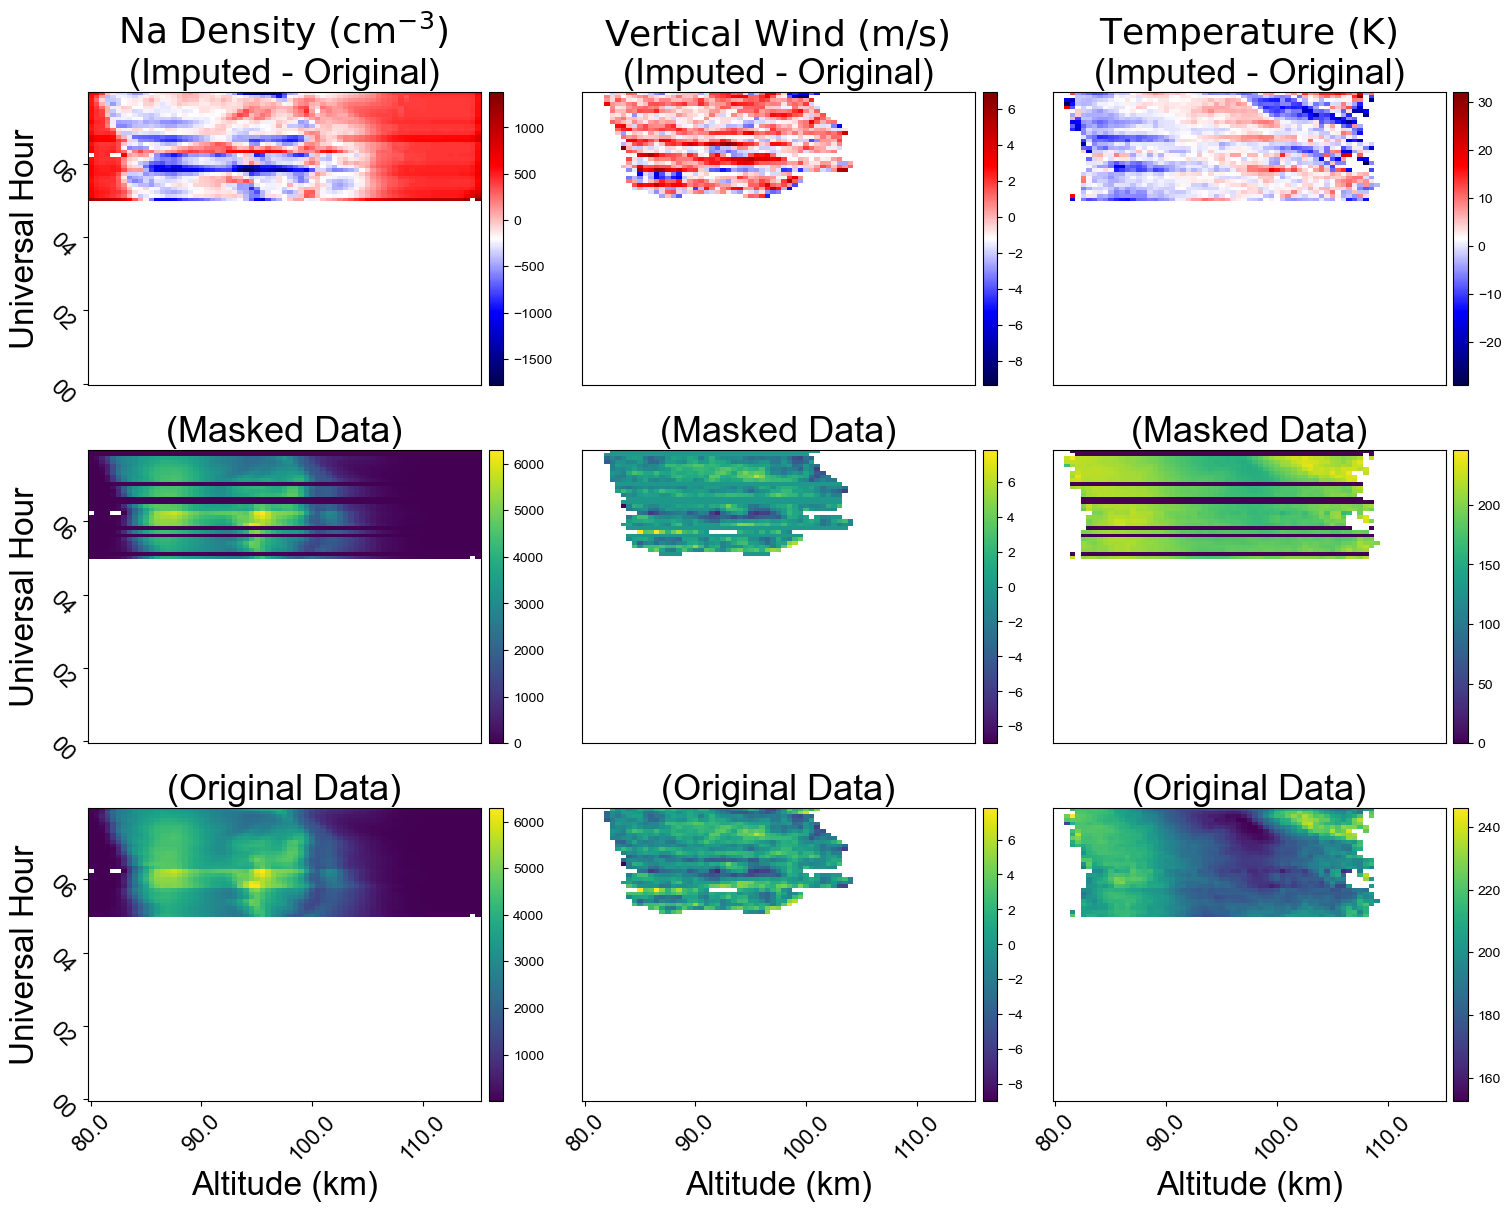

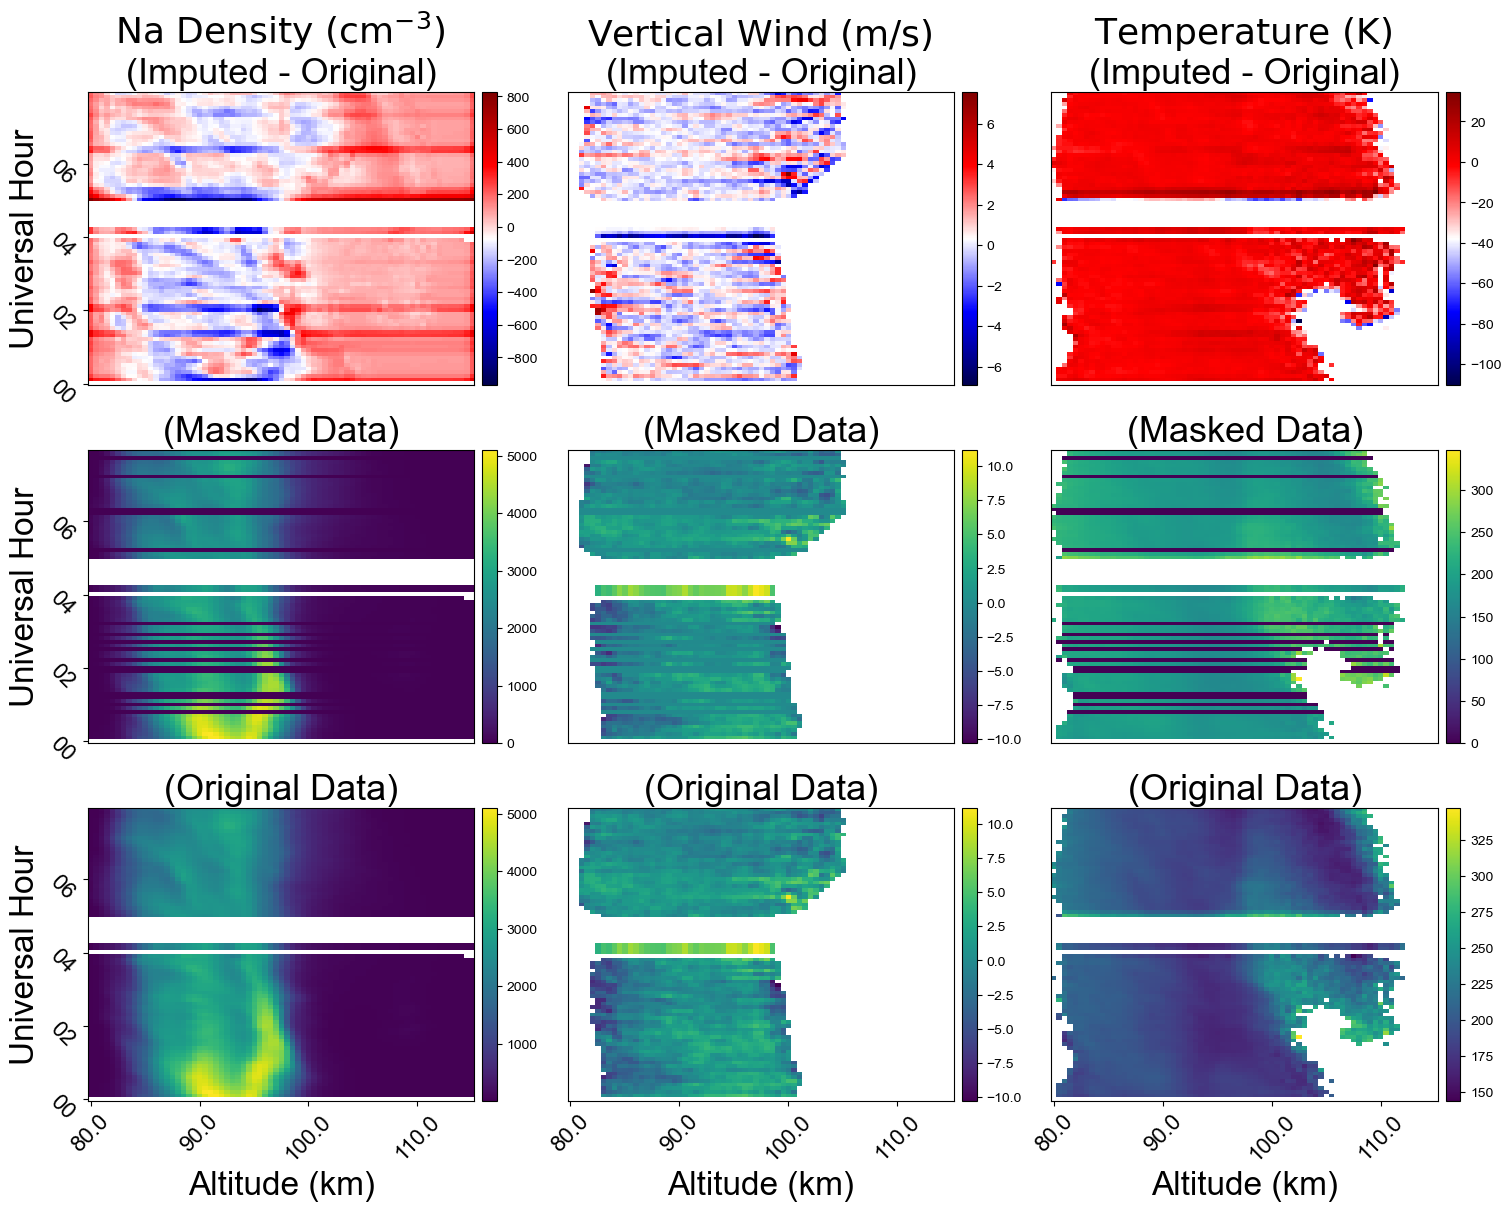

/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/skl

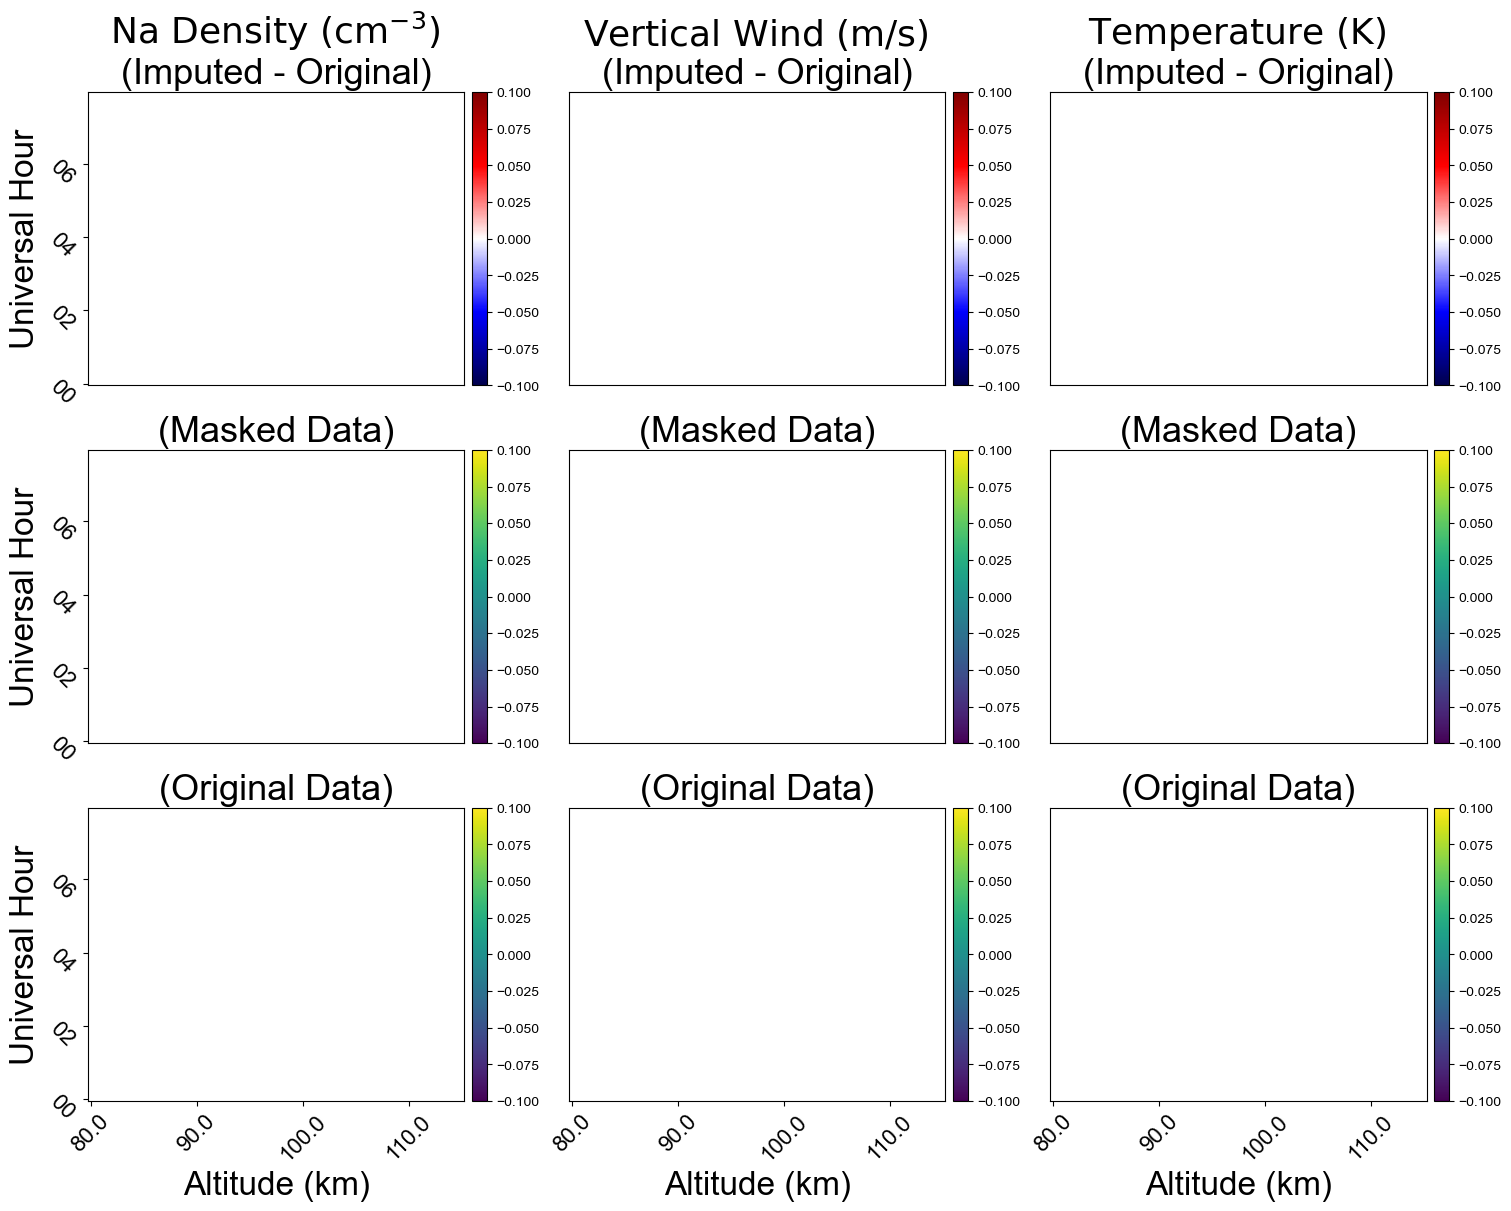

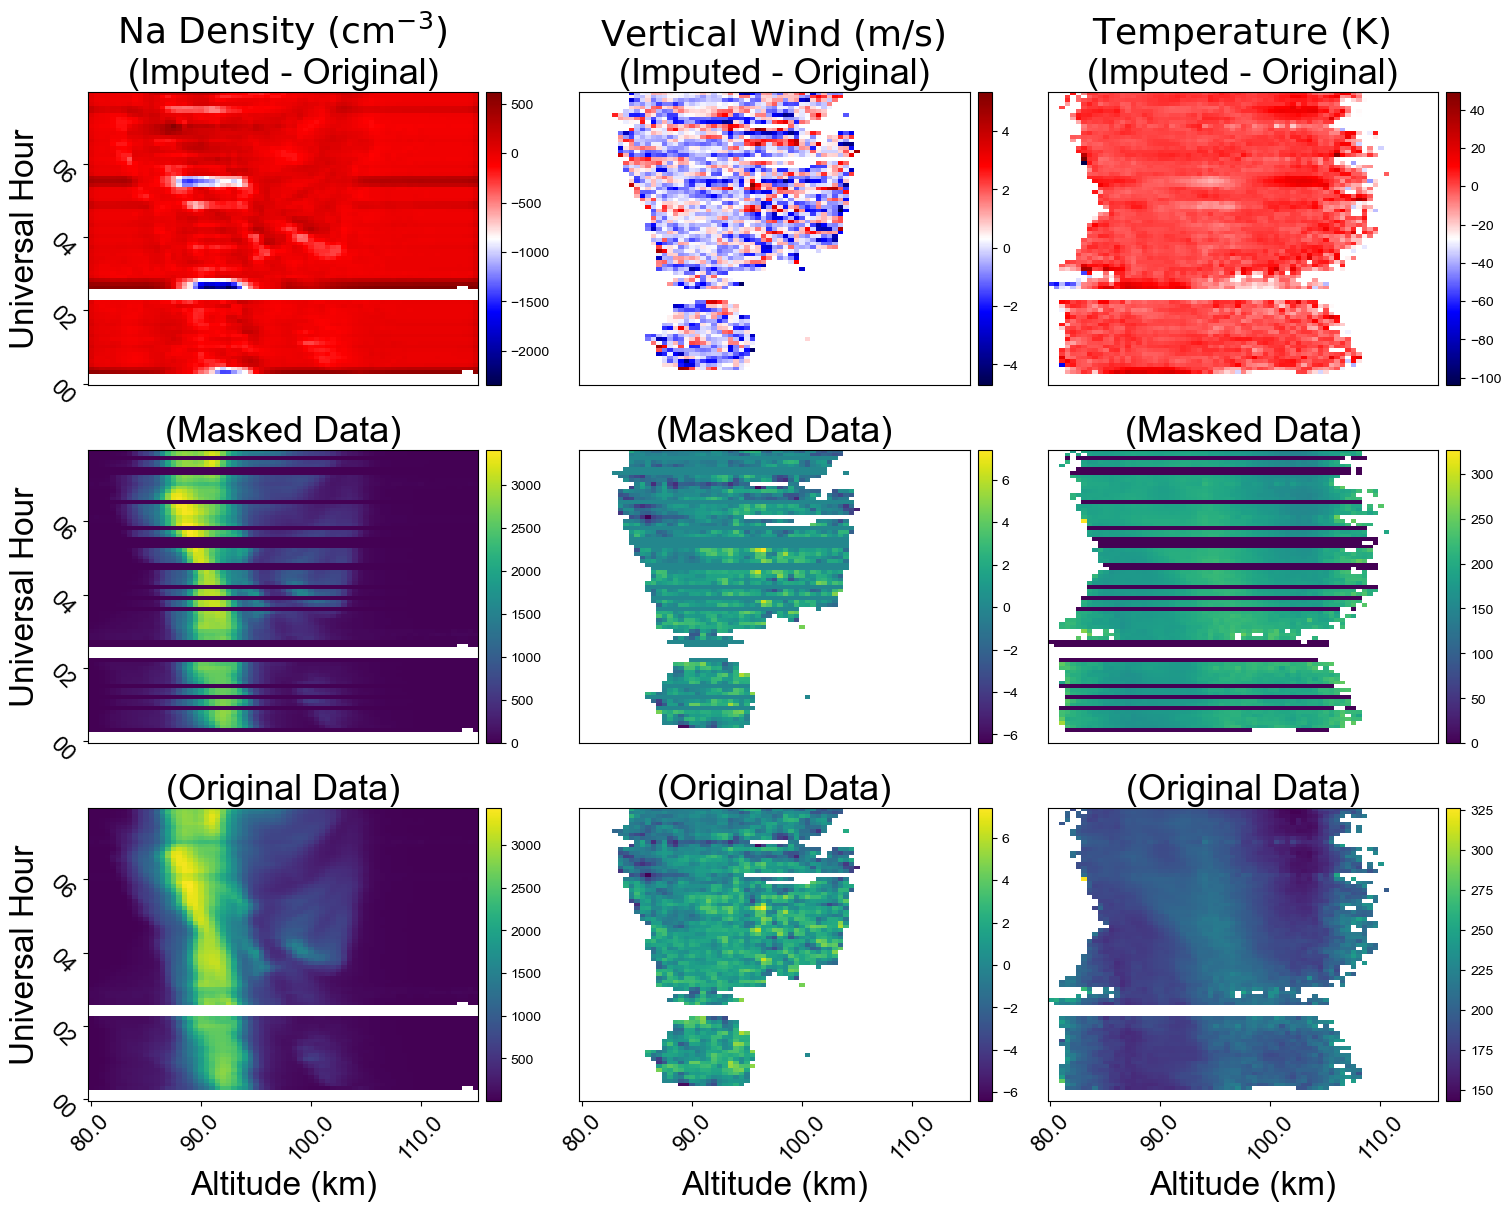

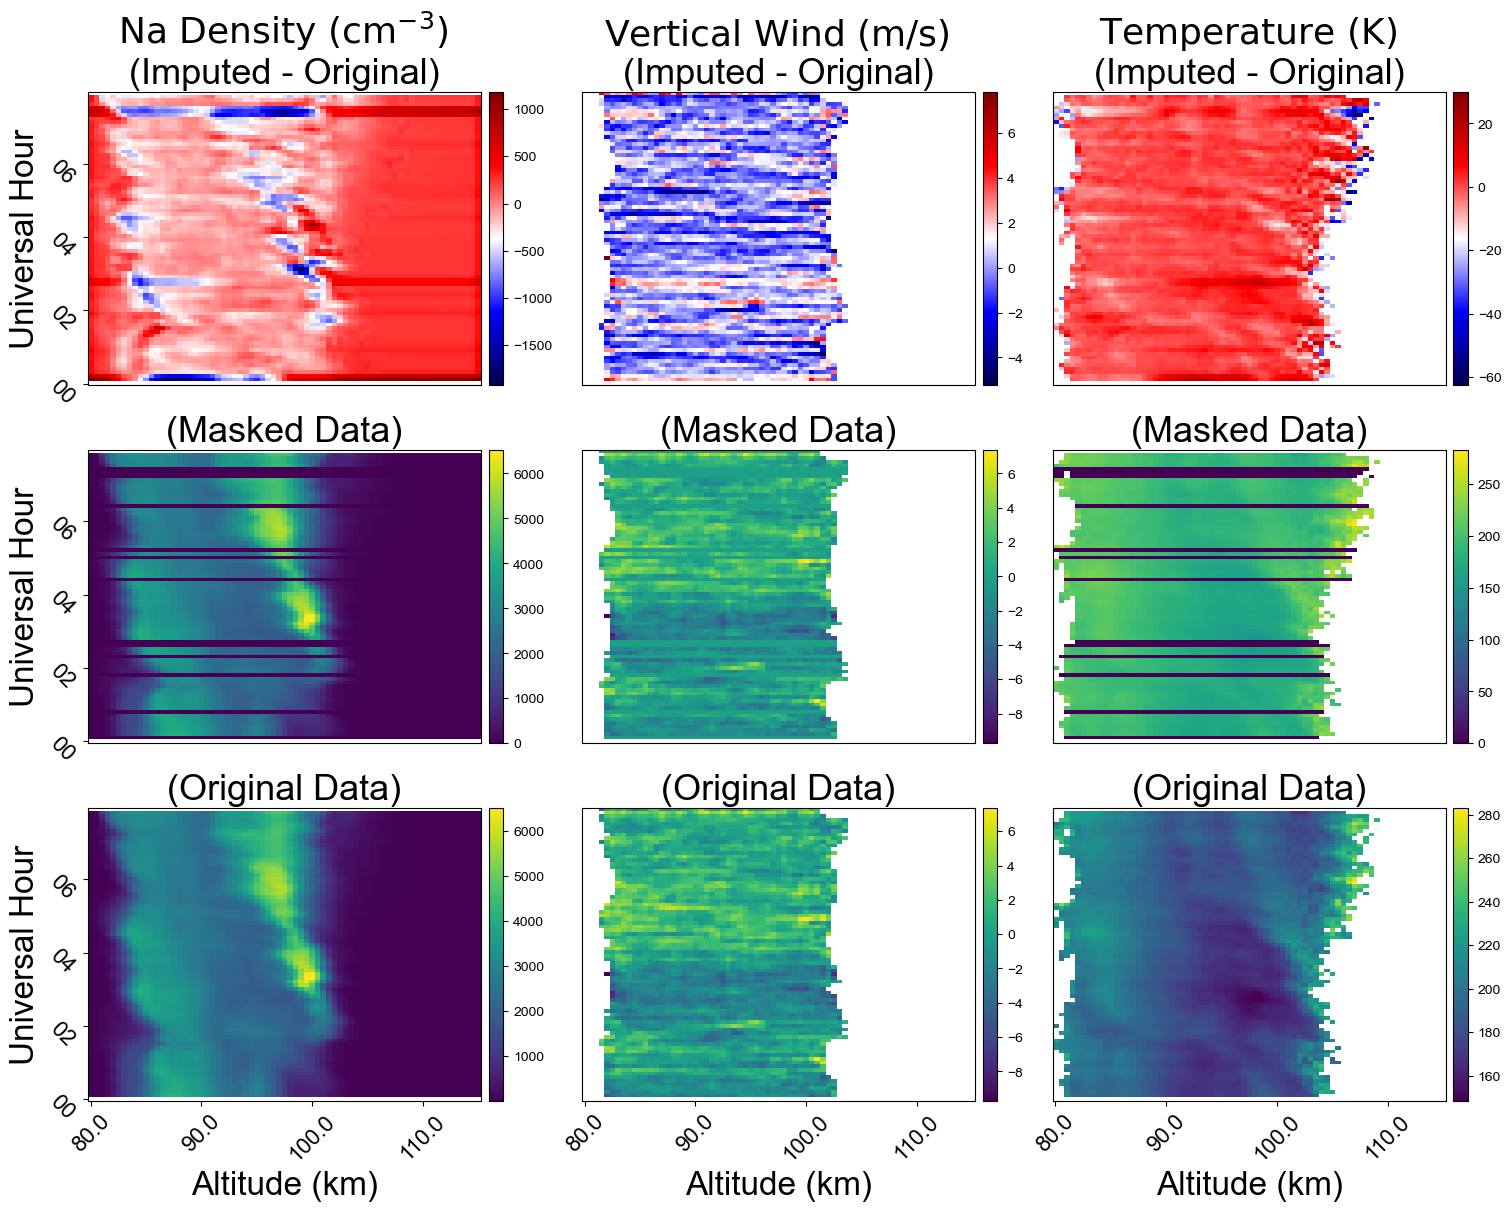

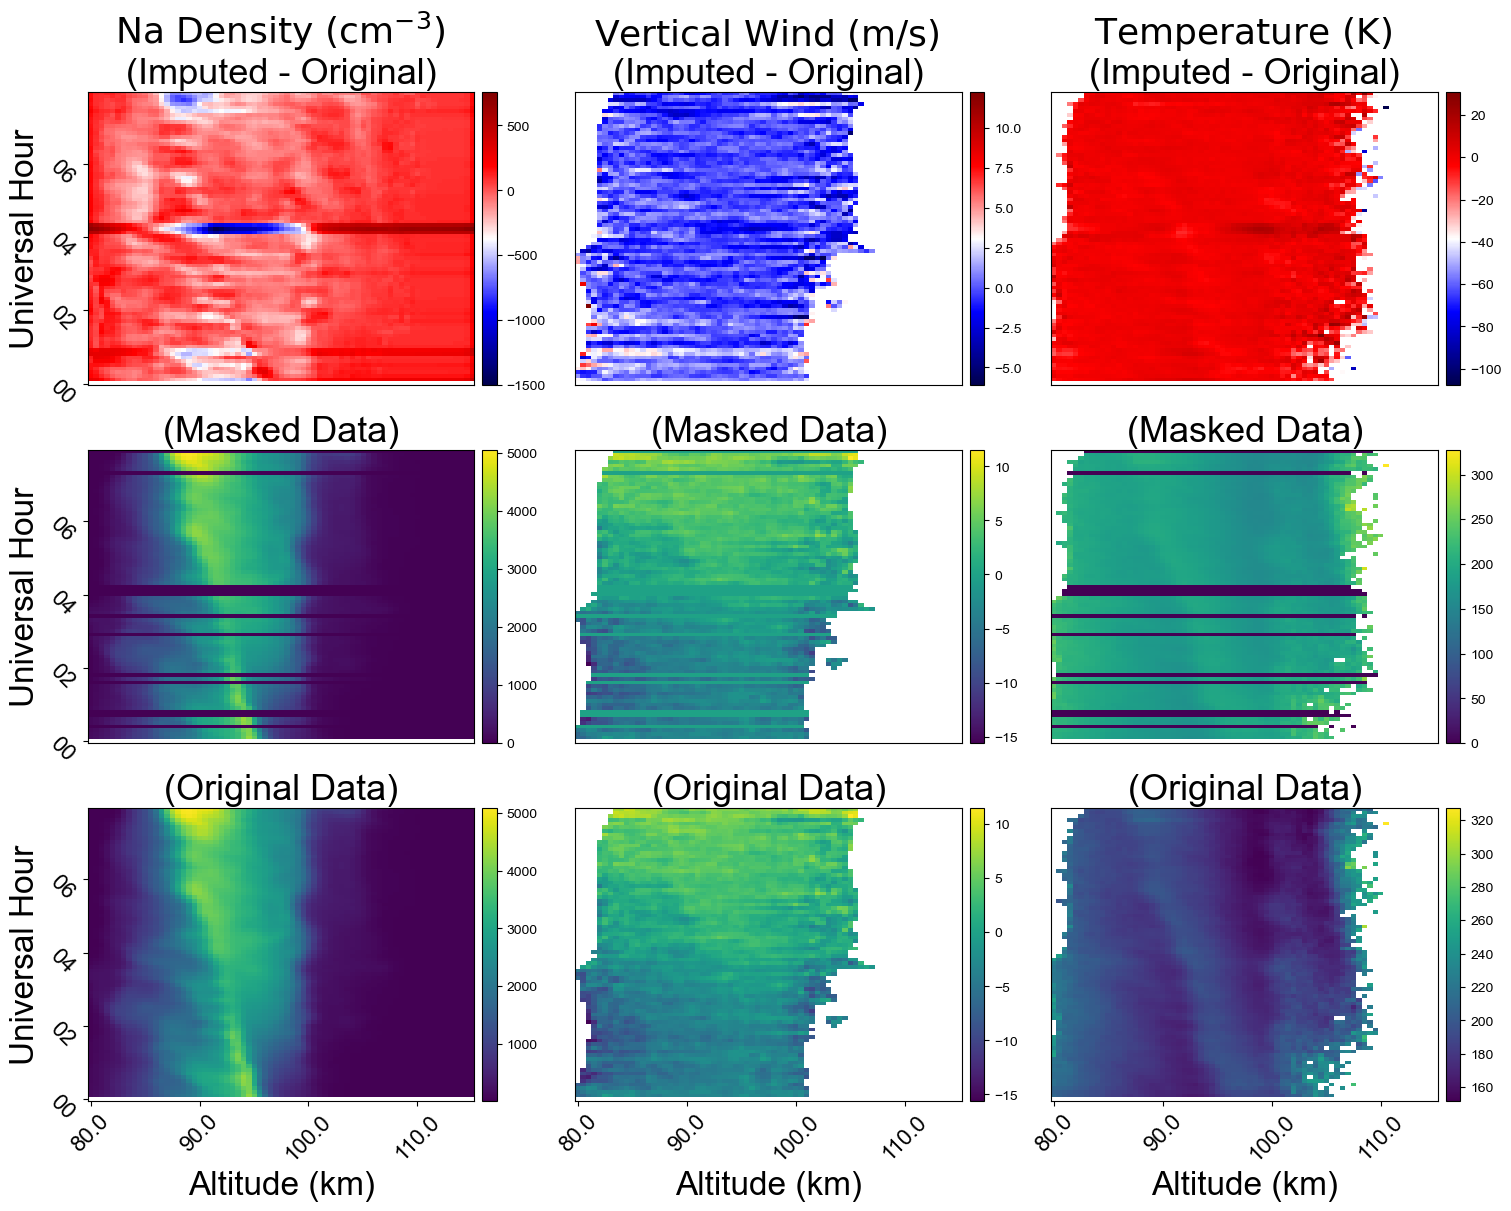

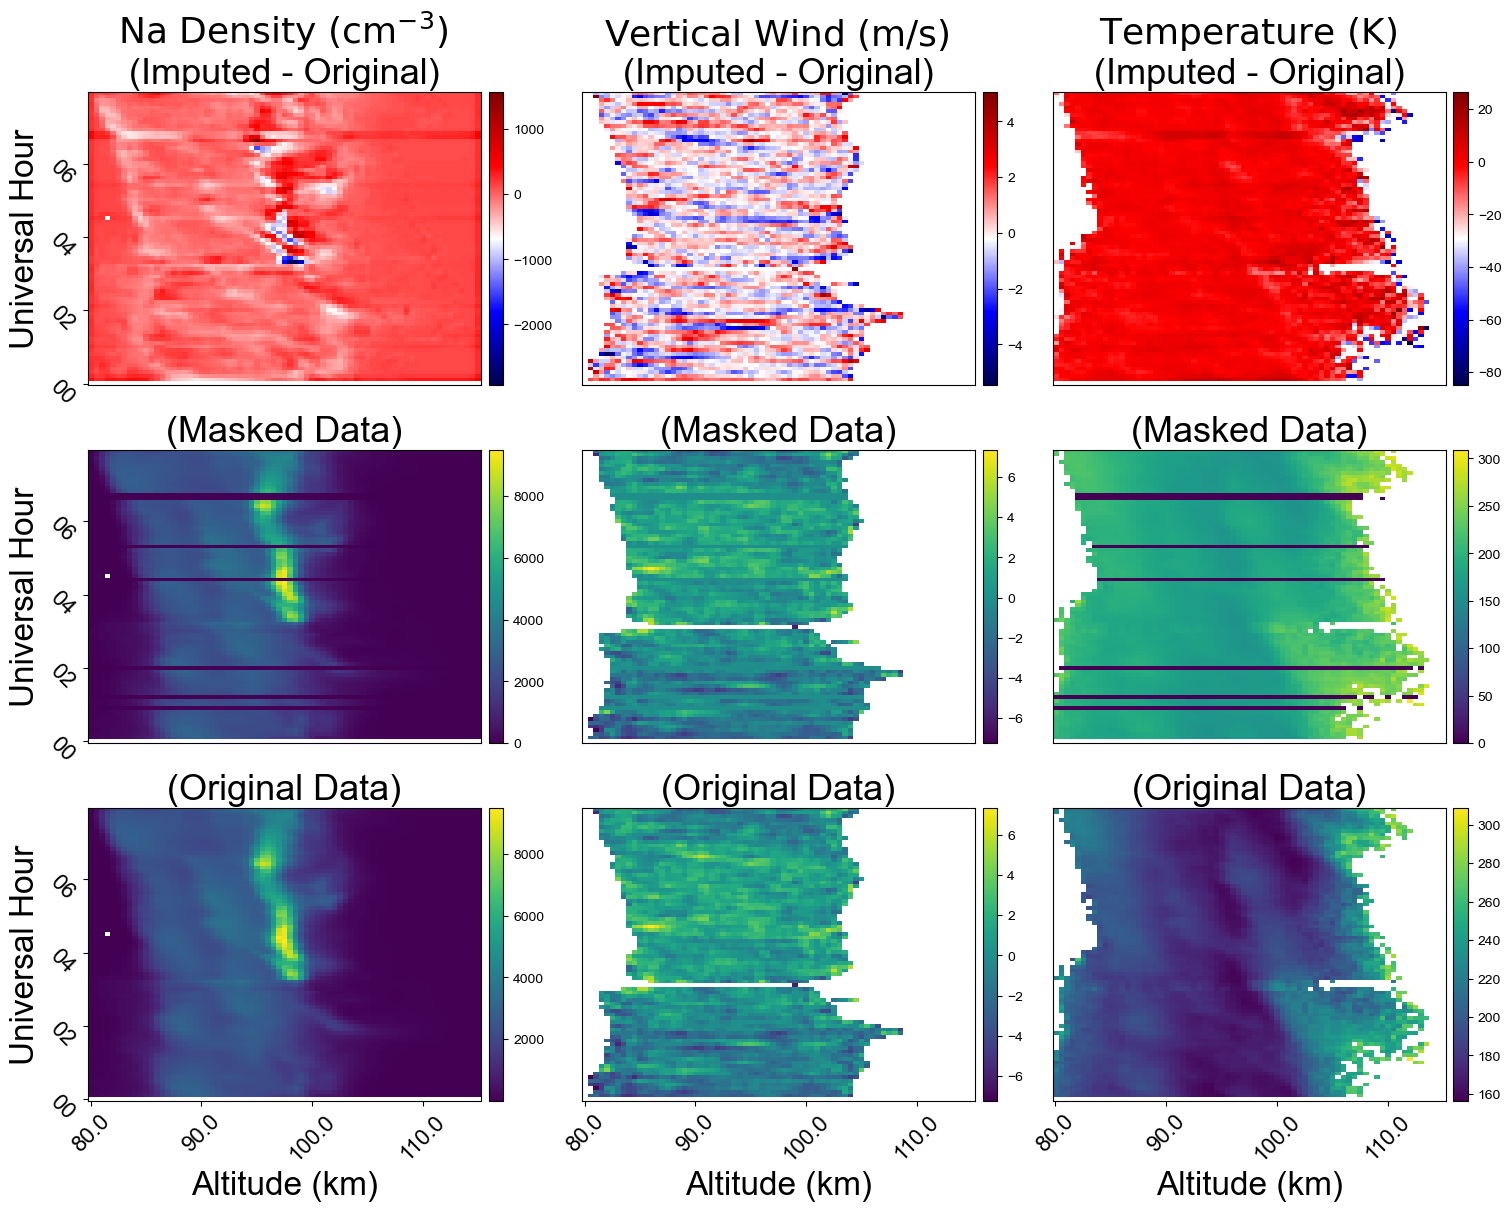

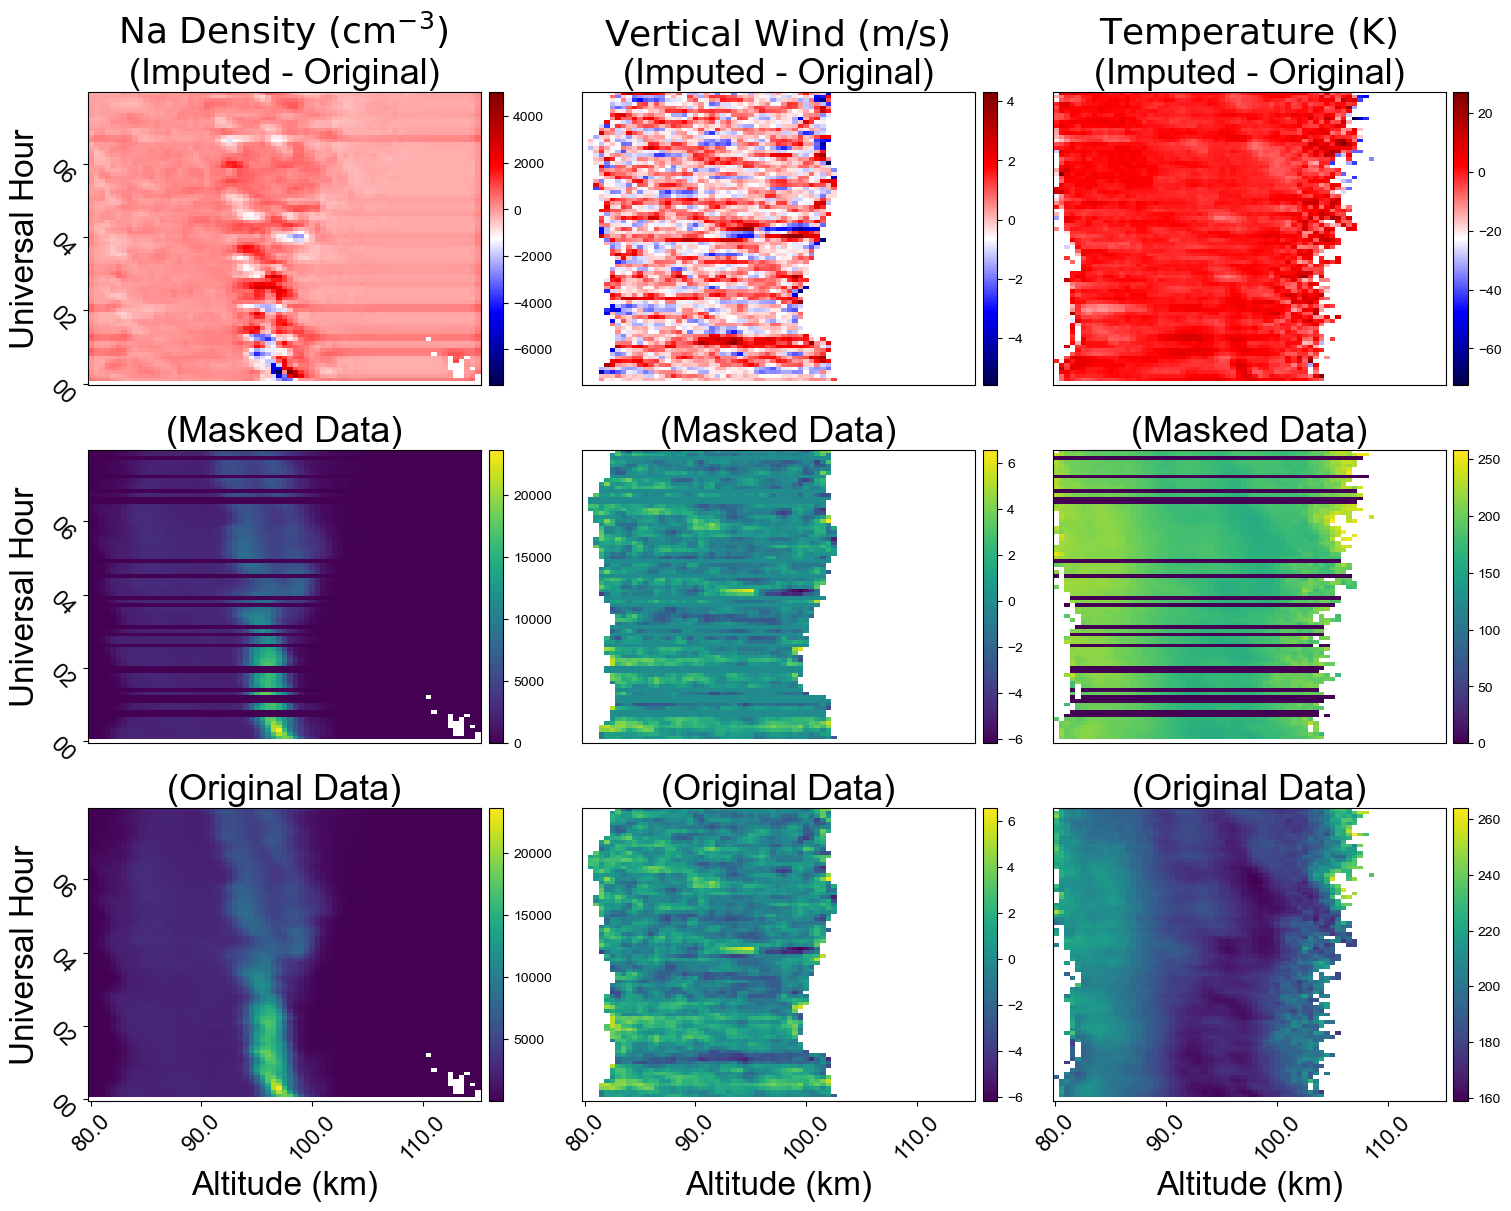

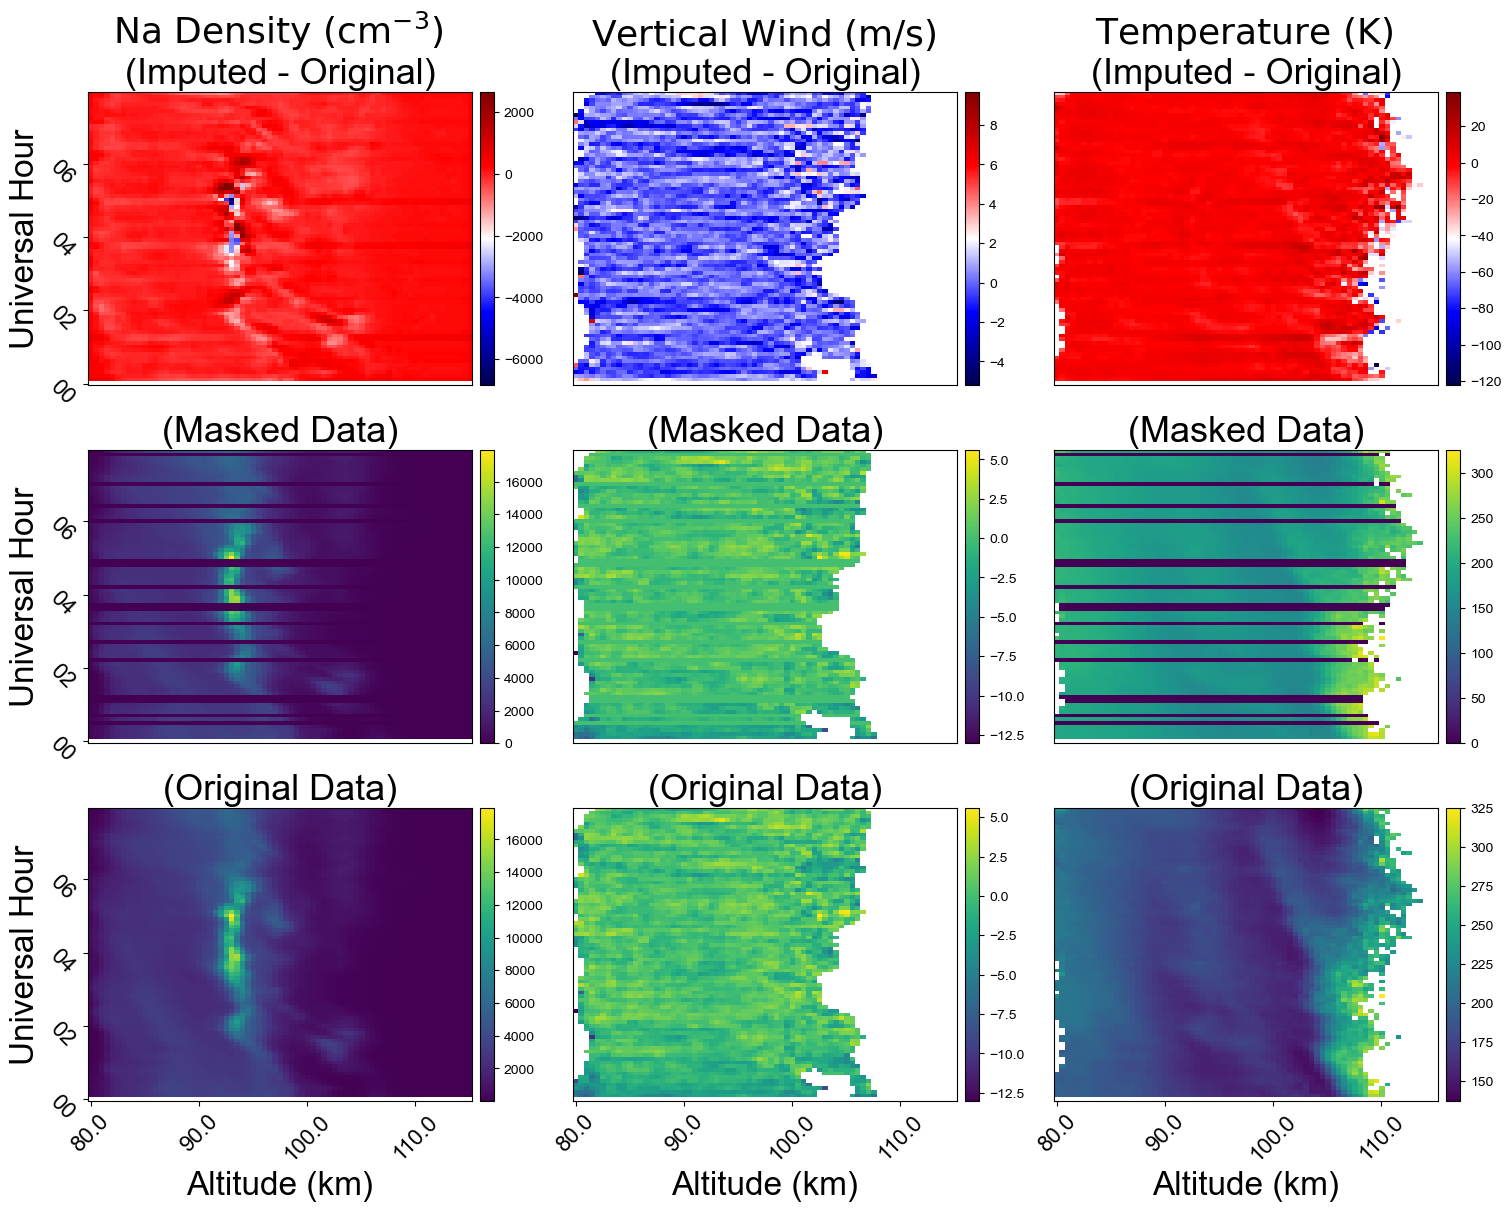

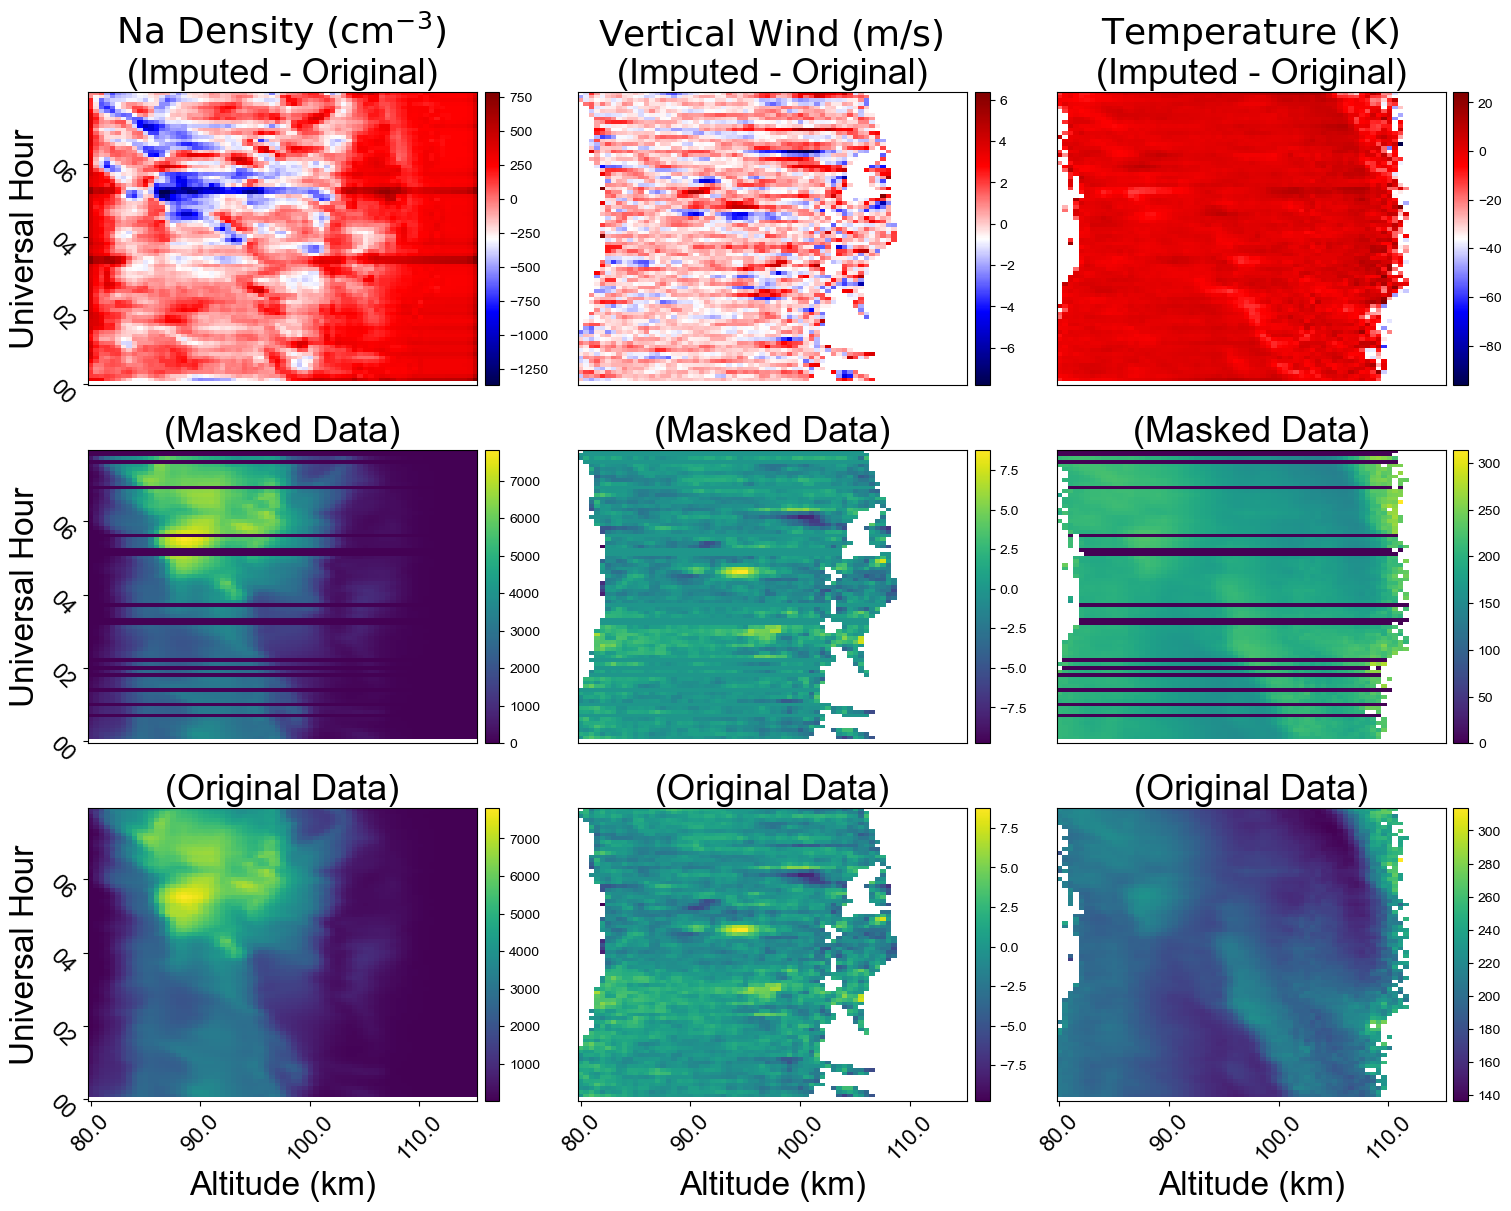

In [65]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Model configuration
CONFIG = {
    "batch_size": 16,
    "time_steps": 80,
    "altitude_levels": 71,
    "input_dim": 3,  # Sodium density, wind, and temperature
    "d_model": 64,  # Reduced embedding dimension
    "nhead": 8,  # Attention heads
    "num_layers": 4,  # Transformer layers
    "dim_feedforward": 256,  # Feedforward layer size
    "num_epochs": 300,
    "window_size": 3,  # Local window size
    "mask_ratio": 0.8,  # Prevent excessive masking
    "step_size": 1,
    "base_weight": 1,
    "lambda_smooth": 1
}

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = MultivariableLocalTransformerWithChannelMixer(
    input_dim=CONFIG["input_dim"],
    d_model=CONFIG["d_model"],
    nhead=CONFIG["nhead"],
    num_layers=CONFIG["num_layers"],
    dim_feedforward=CONFIG["dim_feedforward"],
    window_size=CONFIG["window_size"]
).to(device)

# Load trained model weights
model_path = '/Users/huj7/Desktop/ERAU/MVI-2D-multivariable/Results/newrun/10_10_24/model_epoch_294.pth'
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.eval()

def impute_multivariable_data_local_window(model, data_dir, train_files, start_UT, end_UT, variables, device, mask_ratio):
    """
    Perform multivariable data imputation using a local window approach.
    """
    for filename in train_files:
        # Load and preprocess daily data
        daily_data = load_daily_data(filename, start_UT, end_UT)
        time = daily_data['YYYYMMDD_hhmm']
        altitude = daily_data['Altitudes [km]']
        all_data = np.stack([np.transpose(np.stack(daily_data[var])) for var in variables], axis=-1)
        original_data = all_data.copy()

        # Normalize data
        scalers = {var: StandardScaler() for var in variables}
        for var_idx, var in enumerate(variables):
            var_data = all_data[..., var_idx].reshape(-1, 1)
            scaled_var_data = scalers[var].fit_transform(var_data).reshape(all_data.shape[:-1])
            all_data[..., var_idx] = scaled_var_data

        # Convert data to torch tensors
        train_data = torch.tensor(all_data, dtype=torch.float32).unsqueeze(0).to(device)
        mask_train = (~torch.isnan(train_data)).float()
        train_data = torch.nan_to_num(train_data, nan=0.0)
        target_data = train_data.clone()

        # Prepare DataLoader
        train_dataset = TensorDataset(train_data, target_data, mask_train)
        train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)

        for batch_data, batch_target, batch_mask in train_loader:
            batch_data, batch_target, batch_mask = batch_data.to(device), batch_target.to(device), batch_mask.to(device)

            # Apply masking and imputation
            masked_data, random_mask = mask_slices(batch_data, mask_ratio=mask_ratio)
            
            local_windows, local_masks = extract_local_window(masked_data, random_mask, CONFIG["window_size"], CONFIG["step_size"])
            with torch.no_grad():
                imputed_output = model(local_windows)
                restored_data = restore_output_to_original_shape(
                    imputed_output, 
                    orig_batch_size=batch_data.shape[0],
                    time_steps=CONFIG["time_steps"],
                    altitude_levels=CONFIG["altitude_levels"],
                    window_size=CONFIG["window_size"],
                    step_size=CONFIG["step_size"]
                )
            # Visualization
            plot_imputation_results(original_data, original_data*np.squeeze(random_mask.cpu().detach().numpy()), np.squeeze(restored_data.cpu().detach().numpy()), scalers, variables, time, altitude)
    return restored_data

def plot_imputation_results(original_data, masked_data, restored_data, scalers, variables, time_labels, altitude_labels, 
                            time_step=20, altitude_step=20, fontsize=24, labelsize=16, rotation=45):
    """
    Plot the imputation results with reduced axis labels for a cleaner 3x3 figure.
    """
    num_vars = len(variables)
    rows, cols = 3, num_vars  # Three rows for each type of plot
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), constrained_layout=True)

    # Select reduced labels
    reduced_time_labels = [label.split('_')[1][:2] for label in time_labels[::time_step]]
    reduced_time_indices = range(0, len(time_labels), time_step)
    reduced_altitude_labels = altitude_labels[::altitude_step]
    reduced_altitude_indices = range(0, len(altitude_labels), altitude_step)

    # Map variables to their proper units
    variable_units = {
        "Na Density (cm^(-3))": r"$\text{Na Density (cm}^{-3}\text{)}$",
        "Vertical Wind (m/s)": r"$\text{Vertical Wind (m/s)}$",
        "Temperature (K)": r"$\text{Temperature (K)}$"
    }

    for row in range(rows):
        for col in range(cols):
            var = variables[col]

            # Rescale imputed data
            final_output_rescaled = scalers[var].inverse_transform(
                restored_data[..., col].reshape(-1, 1)
            ).reshape(original_data.shape[0], original_data.shape[1])
            imputed_diff = final_output_rescaled - original_data[..., col]

            # Select the correct data for each row
            if row == 0:  # Imputed - Original
                im = axs[row, col].imshow(imputed_diff, aspect='auto', cmap='seismic', origin='lower')
                axs[row, col].set_title(f"{variable_units[var]} \n(Imputed - Original)", fontsize=fontsize + 2)
            elif row == 1:  # Masked Data
                im = axs[row, col].imshow(masked_data[..., col], aspect='auto', cmap='viridis', origin='lower')
                axs[row, col].set_title(f"(Masked Data)", fontsize=fontsize + 2)
            elif row == 2:  # Original Data
                im = axs[row, col].imshow(original_data[..., col], aspect='auto', cmap='viridis', origin='lower')
                axs[row, col].set_title(f"(Original Data)", fontsize=fontsize + 2)

            # Only show outer axis labels
            if row == rows - 1:  # Only bottom row gets x-axis labels
                axs[row, col].set_xlabel("Altitude (km)", fontsize=fontsize)
                axs[row, col].set_xticks(reduced_altitude_indices)
                axs[row, col].set_xticklabels(reduced_altitude_labels, fontsize=labelsize, rotation=rotation)
            else:
                axs[row, col].set_xticks([])
                axs[row, col].set_xticklabels([])

            if col == 0:  # Only leftmost column gets y-axis labels
                axs[row, col].set_ylabel("Universal Hour", fontsize=fontsize)
                axs[row, col].set_yticks(reduced_time_indices)
                axs[row, col].set_yticklabels(reduced_time_labels, fontsize=labelsize, rotation = -1*rotation)
            else:
                axs[row, col].set_yticks([])
                axs[row, col].set_yticklabels([])

            # Add colorbar
            fig.colorbar(im, ax=axs[row, col], orientation='vertical', pad=0.02)
    plt.show()

# Example usaage
imputed_test_data = impute_multivariable_data_local_window(
    model, data_dir, train_files, start_UT, end_UT, variables, device, mask_ratio=CONFIG["mask_ratio"]
)